<b>The Geography of Climate Migration</b>

*Michał Burzyński* (michal.burzynski@liser.lu), *Frédéric Docquier* (frederic.docquier@liser.lu) & *Hendrik Scheewel* (hendrik.scheewel@uliege.be)

# Load packages

In [1]:
# import packages
import datetime
import io
import itertools
import math
from itertools import cycle
from string import ascii_lowercase as abc

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import geoplot as gplt
from shapely.geometry import Point
import requests
import seaborn as sns
import statsmodels.formula.api as sm
from IPython.display import HTML
from matplotlib import rcParams
from numba import float64, guvectorize, jit, njit, vectorize
from scipy.optimize import minimize
from scipy.stats import gaussian_kde

sns.set_palette('Paired')
colors = sns.color_palette()
sns.set()
sns.set(style="white")
#rcParams['font.family'] = 'monospace'
rcParams['font.family'] = 'serif'

# Latex rendering of fonts
from matplotlib import rc
rc('text', usetex=True)

In [2]:
from ipywidgets import HTMLMath

In [3]:
R = ('a', 'n')                      # regions
S = ('l', 'h')                      # skills
B = ('d', 'f')                      # areas
T = (2010, 2040, 2070, 2100)  # periods of interest

# Model class

In [4]:
class model:
    def __init__(self,
                 name, # name of the model instance
                 σ={'a': math.inf, 'n': 2.0}, # elasticity of substitution
                 μ=1.4, # 1/elasticity of mig. to wages
                 χ={'d': 0.0, 'f': 0.5}, # income loss due to forced discplacement
                 τ={'a': 0.0, 'n': 0.0}, # utility loss due to CLC
                 tol=1e-10, # tolerance parameter
                 inputs='inputs.xlsx', # input of data
                 scenario='intermediate'): # climate change scenario
        
        self.σ, self.τ, self.μ, self.χ, self.tol  = σ, τ, μ, χ, tol
        
        self.name = name
        
        def get_input(which, dim): 
            ''' Function that unpacks inputs of the model '''
            return pd.read_excel(inputs,
            sheet_name=dim,
            index_col=0,
            header=list(range(len(dim)))).sort_index()

        # Load country-specific data
        # i = country-specific
        data_i = get_input(inputs, 'i')
        data_i.index.name = 'Country'
        # irt  = country-region-time-specific
        data_irt = get_input(inputs, 'irt')
        data_irt.columns.names = ['Variable','r','t']
        data_irt.index.name = 'Country'
        # irst = country-region-skill-time-specific
        data_irst = get_input(inputs, 'irst')
        data_irst.columns.names = ['Variable','r','s','t']
        data_irst.index.name = 'Country'
        # irsbt = country-region-skill-area-time-specific
        data_irsbt = get_input(inputs, 'irsbt')  
        data_irsbt.columns.names = ['Variable','r','s','b','t']
        data_irsbt.index.name = 'Country'
        # irsbt = origin-destination-region-skill-time-specific
        data_ijrst = get_input(inputs, 'ijrsbt') 
        data_ijrst.columns.names = ['Variable','r','s','b','t','Destination']
        data_ijrst.index.name = 'Country'
        
        # Assign country-specific data
        self.countries = data_i.index
        self.OECD = data_i['OECD'] # OECD indicator
        self.iso = data_i['iso3'] # iso3 Code
        self.wbregion = data_i['wbregion'] # World Bank region
        self.income_group = data_i['income_group'] # Income group
        self.georegion = data_i['georegion'] # Geographical region
        self.bddm = data_i['bddm'] # BDDM regions
        self.latitude = data_i['latitude'] # Latitude
        self.longitude = data_i['longitude'] # Latitude
        self.Y = data_irt['Y'] # GDP
        self.Γ__w = data_irt['Γ__w'] # high-to-low-skill wage ratio
        self.L = data_irst['L'] # resident population
        self.mii = data_irsbt['mii'] # emigrant to stayer ratio (internal)
        self.Mij = data_ijrst['Mij'] # number of emigrants
        self.n = data_irsbt['n']
        self.p = data_irsbt['p']
        
        
        # Climate change damage scenario
        self.D = pd.read_excel(inputs,
            sheet_name='scenarios',
            index_col=0,
            header=[0,1,2,3])[scenario]['D']
        self.D.columns.names = ['r','t']
        
        self.ω = pd.read_excel(inputs,
            sheet_name='scenarios',
            index_col=0,
            header=[0,1,2,3])[scenario]['ω']
        self.ω.columns.names = ['r','t']
        
        # Geodataframe containing shape information
        self.shapes = gpd.read_file('shapes/shapes.shp').set_index('Country')
        
        # Lexsort all dataframes:
        for i in list(self.__dict__):
            if isinstance(self.__dict__[i],pd.DataFrame):
                try:
                    if self.__dict__[i].columns.is_lexsorted() == False:
                        self.__dict__[i].columns.sortlevel(inplace=True)
                except:
                    pass

                
        self.Y_data = self.Y
        self.Γ__w_data = self.Γ__w
        self.L_data = self.L
        self.Mij_data = self.Mij

In [5]:
def MidxDataFrame(self,dim,value=np.nan):
    """ Creates multi-indexed empty dataframe with country-index"""
    
    MultiIndexDic = {
    'irt': {
        'levels': [R,T],
        'names': ['r','t'],
    },
    'ist': {
        'levels': [S,T],
        'names': ['s','t'],
    },
    'irs': {
        'levels': [R,S],
        'names': ['r','s'],
    },
    'irst': {
        'levels': [R,S,T],
        'names': ['r','s','t'],
    },
    'irsbt': {
        'levels': [R,S,B,T],
        'names': ['r','s','b','t'],
    },
    'ijrs': {
        'levels': [R,S,list(self.countries)],
        'names': ['r','s','Destination'],
    },
    'ijrst': {
        'levels': [R,S,T,list(self.countries)],
        'names': ['r','s','t','Destination']
    },
    'ijrsbt': {
        'levels': [R,S,B,T,list(self.countries)],
        'names': ['r','s','b','t','Destination']
    },
    'ijrsft': {
        'levels': [R,S,['f'],T,list(self.countries)],
        'names': ['r','s','b','t','Destination']}}
    
    
    return(pd.DataFrame(value, index=self.countries,
                        columns=pd.MultiIndex.from_product(
                            MultiIndexDic[dim]['levels'],
                            names=MultiIndexDic[dim]['names']).sortlevel()[0]))

model.MidxDataFrame = MidxDataFrame

## Functions

### Calibration functions

In [6]:
#############################
''' Calibration functions '''
#############################

# The following two functions are the inverse functions of mii and mij
def xii_fun(self,r, s):
    ''' internal migration cost'''
    return(1 - self.mii[(r,s,'d',2010)]**self.μ * (self.v[(r,s,'d',2010)]/self.v[('n',s,'d',2010)]))

model.xii_fun = xii_fun

def xij_fun(self,r, s):
    ''' international migration cost '''
    return(np.array(1 - self.mij[(r,s,'d',2010)]**self.μ * (1/self.V[(r,s,'d',2010)])\
                    * (1 - np.diag(np.ones(len(self.countries))))))

model.xij_fun = xij_fun

### Model functions

In [7]:
#######################
''' Model functions '''
#######################

def Γ__L_fun(self,r, t):
    ''' Skill ratio in the labor force '''
    return(self.L[(r, 'h', t)] / self.L[(r, 'l', t)])

model.Γ__L_fun = Γ__L_fun

def Γ__η_fun(self, r, t):
    ''' Skill bias in relative productivity '''
    return(self.Γ__η_bar[r] * self.Γ__L[(r, t)]**self.κ[r])

model.Γ__η_fun = Γ__η_fun

def η_fun(self, r, s, t):
    ''' Relative productivity '''
    if s == 'h':
        return(self.Γ__η[(r, t)] / (1 + self.Γ__η[(r, t)]))
    else:
        return(1 / (1 + self.Γ__η[(r, t)]))
    
model.η_fun = η_fun


def A_fun(self, r, t):
    ''' Total factor productivity '''
    return (self.γ**(t - 2010) * self.D[(r, t)] * self.A_bar[r] * self.Γ__L[(r, t)]**self.ε[r])

model.A_fun = A_fun

def Y_fun(self, r, t):
    ''' Gross domestic product '''
    if r == 'n':
        return(self.A[(r, t)]\
               * (self.η[(r, 'l', t)] * self.L[(r, 'l', t)]**((self.σ[r]-1)/self.σ[r])\
                  + self.η[(r, 'h', t)] * self.L[(r, 'h', t)]**((self.σ[r]-1)/self.σ[r]))**(self.σ[r]/(self.σ[r]-1)))
    else:
        return(self.A[(r, t)] * (self.η[(r, 'l', t)] * self.L[(r, 'l', t)] + self.η[(r, 'h', t)] * self.L[(r, 'h', t)]))

model.Y_fun = Y_fun

def w_fun(self, r, s, t):
    ''' Wage rate '''
    if r == 'a':
        return (self.η[(r, s, t)] * self.A[(r, t)])
    if r == 'n':
        return (self.η[(r, s, t)] * self.A[(r, t)] ** ((self.σ[r]-1)/self.σ[r]) 
                * (self.Y[(r, t)] / self.L[(r, s, t)])**(1 / self.σ[r]))
    
model.w_fun = w_fun
    
def Γ__w_fun(self, r, t):
    ''' High-low-skilled wage ratio '''
    return(self.w[(r, 'h', t)]/self.w[(r, 'l', t)])

model.Γ__w_fun = Γ__w_fun

def c_fun(self, r, s, b, t):
    ''' Consumption '''
    return(self.w[(r, s, t)] )

model.c_fun = c_fun


def v_fun(self, r, s, b, t):
    ''' Inner utility '''
    return((1 - self.τ[r]) * self.c[(r, s, b, t)])

model.v_fun = v_fun

def V_fun(self, r, s, b, t):
    ''' Relative utility between two regions '''
    return(np.outer(1/self.v[(r,s,b,t)],self.v[('n',s,'d',t)]))

model.V_fun = V_fun

def mii_fun(self, r, s, b, t):
    ''' Internal emigrant to stayer ratio '''
    return(((self.v[('n', s, 'd', t)]/self.v[(r, s, b, t)])
            * ( (1-self.xii[(r, s)])/(1-self.χ[b])))**(1/self.μ))

model.mii_fun = mii_fun

def mij_fun(self, r, s, b, t):
    ''' International emigrant to stayer ratio'''
    return(np.array(self.V[(r,s,'d',2010)]**(1/self.μ)\
                    * ((1-self.xij[(r,s)])/(1-self.χ[b]))**(1/self.μ)\
                    * (1-np.diag(np.ones(len(self.countries))))))    

model.mij_fun = mij_fun

def Ms_fun(self, r, s, b, t):
    """ Stayers """
    if b == 'd':
        share = 1-self.ω[(r,t)]
    else:
        share = self.ω[(r,t)]
    return((share * self.N[(r, s, t)])/
           (1 + self.mii[(r, s, b, t)] + self.mij[(r,s,b,t)].sum(1)))

model.Ms_fun = Ms_fun

def Mii_fun(self, r, s, b, t):
    """ Internal emigrants from dry area """
    return(self.mii[(r, s, b, t)] * self.Ms[(r, s, b, t)])

model.Mii_fun = Mii_fun

def Mij_fun(self, r, s, b, t):
    """ Internal emigrants from dry area """
    return(np.array(self.mij[(r,s,b,t)].multiply(self.Ms[(r,s,b,t)],0)))

model.Mij_fun = Mij_fun

def Iii_fun(self, r,s,t):
    """ Internal immigrant flow"""
    rprime = set(R).difference(r).pop()
    return(self.Mii[(rprime,s,'d',t)] + self.Mii[(rprime,s,'f',t)])

model.Iii_fun = Iii_fun

def Iij_fun(self, r, s, t):
    ''' International immigrant flow '''
    if r == 'a':
        return(0)
    else:
        return((self.Mij[('a',s,'d',t)] + self.Mij[('a',s,'f',t)] \
              + self.Mij[('n',s,'d',t)] + self.Mij[('n',s,'f',t)]).sum(0)) 
    
model.Iij_fun = Iij_fun

def L_fun(self, r,s,t):
    ''' Resident population '''
    rprime = set(R).difference(r).pop()
    L = self.Ms[(r, s, 'd', t)]  +\
        self.Ms[(r, s, 'f', t)]  +\
        self.Iii[(r,s,t)] +\
        self.Iij[(r,s,t)]
    return(np.maximum(self.tol, L))

model.L_fun = L_fun

def N_fun(self, r, s, t):
    ''' Native population '''
    if t < 2040:
        if s == 'l':
            # probabilities to become low-skilled
            p_l = 1 - self.p[(r, 'l', 'd', t-30)]
            p_h = 1 - self.p[(r, 'h', 'd', t-30)]
        else:
            # probabilities to become high-skilled
            p_l = self.p[(r, 'l', 'd', t-30)]
            p_h = self.p[(r, 'h', 'd', t-30)]
        N = self.L[(r, 'l', t-30)] * self.n[(r, 'l', 'd', t-30)] * p_l + \
            self.L[(r, 'h', t-30)] * self.n[(r, 'h', 'd', t-30)] * p_h
    else:
        rprime = set(R).difference(r).pop()
        p_l  = self.p[(r,'h','d',t-30)]
        p_h  = self.p[(r,'h','d',t-30)]
        pf_l = self.p[(r,'l','f',t-30)]
        pf_h = self.p[(r,'h','f',t-30)]
        if s == 'l':
            p_l  = 1 - p_l
            pf_l = 1 - pf_l
            p_h  = 1 - p_h
            pf_h = 1 - pf_h
        N = self.Ms[(r, 'l', 'd', t-30)]       * self.n[(r, 'l', 'd', t-30)] * p_l  +\
            self.Ms[(r, 'l', 'f', t-30)]       * self.n[(r, 'l', 'f', t-30)] * pf_l +\
            self.Mii[(rprime, 'l', 'd', t-30)] * self.n[(r, 'l', 'd', t-30)] * p_l  +\
            self.Mii[(rprime, 'l', 'f', t-30)] * self.n[(r, 'l', 'f', t-30)] * pf_l +\
            self.Ms[(r, 'h', 'd', t-30)]       * self.n[(r, 'h', 'd', t-30)] * p_l  +\
            self.Ms[(r, 'h', 'f', t-30)]       * self.n[(r, 'h', 'f', t-30)] * pf_l +\
            self.Mii[(rprime, 'h', 'd', t-30)] * self.n[(r, 'h', 'd', t-30)] * p_l  +\
            self.Mii[(rprime, 'h', 'f', t-30)] * self.n[(r, 'h', 'f', t-30)] * pf_l
    return(np.maximum(self.tol, N))

model.N_fun = N_fun

## Calibration

### Calibration of technology

In [8]:
def technology_calib(self):
    self.κ = {'a': 0.0, 'n': 0.198009171657804}
    self.Γ__η_bar = {'a': 1.32558139534884, 'n': 1.878}
    self.Γ__L = self.MidxDataFrame('irt')
    self.Γ__η = self.MidxDataFrame('irt')
    self.η = self.MidxDataFrame('irst')
    self.A = self.MidxDataFrame('irt')
    self.A_bar = pd.DataFrame(index=self.countries)
    self.ε = {'a': np.nan, 'n': np.nan}  
    self.ε['a'] = 0.324228560775267
    self.ε['n'] = 0.276894909527694
    self.γ = 1.00256317290118

    t = 2010

    for r in R:
        self.Γ__L[(r,t)] = self.L[(r,'h',t)]/self.L[(r,'l',t)]
    for r in R:
        if r == 'n':
            self.Γ__η[(r,t)] = (self.Γ__w[(r,t)] *(self.Γ__L[(r,t)])**(1/self.σ[r]))
        else:
            self.Γ__η[(r,t)] = self.Γ__η_bar[r]
            
    t = 2010
    df = pd.DataFrame({'Γ__η': self.Γ__η[('n',t)],'Γ__L': self.Γ__L[('n',t)]})
    reg = sm.ols(formula="np.log(Γ__η) ~ np.log(Γ__L)", data=df).fit()

    self.κ['n'] = 0.5*reg.params['np.log(Γ__L)']
    self.Γ__η_bar['n'] = np.exp(reg.params['Intercept'])
    
    self.Γ__η_bar = pd.DataFrame(index=self.countries)
    
    for r in R:
        self.Γ__η_bar[r] = self.Γ__η[(r,t)]/((self.Γ__L[(r,t)])**(self.κ[r]))
        
    
    for r in R:
        self.Γ__η[(r,t)] = (self.Γ__η_bar[r] *(self.Γ__L[(r,t)])**(self.κ[r]))
    
    
    for r in R:
        for s in S:
            if s == 'h':
                self.η[(r, s, t)] = self.Γ__η[(r, t)] / (1 + self.Γ__η[(r, t)])
            else:
                self.η[(r, s, t)] = 1 / (1 + self.Γ__η[(r, t)])
    

    for r in R:
        if r == 'a':
            self.A[(r,t)] = ((self.Y[(r, t)]) /\
                      (self.η[(r,'l',t)] * self.L[(r,'l',t)] +\
                       self.η[(r,'h',t)] * self.L[(r,'h',t)]))
        else:
            self.A[(r,t)] = (self.Y[(r, t)] /\
                     (self.η[(r,'l',t)] * (self.L[(r,'l',t)])**((self.σ[r]-1)/self.σ[r]) +\
                      self.η[(r,'h',t)] * (self.L[(r,'h',t)])**((self.σ[r]-1)/self.σ[r]))**(self.σ[r]/(self.σ[r]-1)))
            
    for r in R:
        self.A_bar[r] = self.A[(r,t)]/(self.γ**(t - 2010) * (self.Γ__L[(r,t)])**self.ε[r] * self.D[(r,t)])


    def A_fun(r, t):
        ''' Total factor productivity '''
        return (self.A_bar[r] * self.γ**(t - 2010)* self.Γ__L[(r, t)]**self.ε[r] * self.D[(r, t)])
        
    def Y_fun(r, t):
        ''' Gross domestic product '''
        if r == 'n':
            return(self.A[(r, t)]\
                   * (self.η[(r, 'l', t)] * self.L[(r, 'l', t)]**((self.σ[r]-1)/self.σ[r])\
                      + self.η[(r, 'h', t)] * self.L[(r, 'h', t)]**((self.σ[r]-1)/self.σ[r]))**(self.σ[r]/(self.σ[r]-1)))
        else:
            return(self.A[(r, t)] * (self.η[(r, 'l', t)] * self.L[(r, 'l', t)] + self.η[(r, 'h', t)] * self.L[(r, 'h', t)]))
    
    self.κ_calib = self.κ
    self.ε_calib = self.ε
    self.σ_calib = self.σ
    self.A_calib = self.A    
    self.Γ__L_calib = self.Γ__L
    self.Γ__η_calib = self.Γ__η           
    self.η_calib = self.η
    
    #### TRY TO PREDICT Y HERE:
    t = 2010
    for r in R:
        self.A[(r,t)] = A_fun(r, t)
    for r in R:
        self.Y[(r,t)] = Y_fun(r, t)    
    
model.technology_calib = technology_calib

In [9]:
def Γ__L_cal(self,r, t):
    ''' Skill ratio in the labor force '''
    return (self.L[(r, 'h', t)] / self.L[(r, 'l', t)])

### Calibration of migration costs

In [10]:
def calib_migcosts(self):
    """ Calibration of migration costs """
    
    t = 2010
    
    # Create empty dataframes for emigrant to stayer ratios, stayers and migrants
    self.N = self.MidxDataFrame('irst')
    self.miF = self.MidxDataFrame('irst')
    self.Ms = self.MidxDataFrame('irsbt')
    self.Mii = self.MidxDataFrame('irsbt')
    self.MiF = self.MidxDataFrame('irst')

    for s in S:
        v_n_s       = 1 # share of immigrants that goes to urban area
        m_an_s      = self.mii[('a',s,'d',2010)] # exog. rural internal emigrant-to-stayer ratio
        m_na_s      = 0 # urban internal emigrant-to-stayer ratio
        
        L_a_s_hat   = self.L[('a',s,2010)] # rural residents
        L_n_s_hat   = self.L[('n',s,2010)] # urban residents
        L_s_hat     = L_a_s_hat + L_n_s_hat # all residents
        
        M_aF_s_hat  = self.Mij.xs(['a',s,'d',2010],1,[0,1,2,3]).sum(1) # rural emigrants
        M_nF_s_hat  = self.Mij.xs(['n',s,'d',2010],1,[0,1,2,3]).sum(1) # urban emigrants
        M_F_s_hat   = M_aF_s_hat + M_nF_s_hat # all emigrants
        
        I_Fa_s_hat  = self.Mij.xs(['a',s,'d',2010],1,[0,1,2,3]).sum(0) # rural immigrants
        I_Fn_s_hat  = self.Mij.xs(['n',s,'d',2010],1,[0,1,2,3]).sum(0) # urban immigrants
        I_s_hat     = I_Fa_s_hat + I_Fn_s_hat # all immigrants
        
        N_s_hat     = L_s_hat + M_F_s_hat - I_s_hat # all natives

        # for all countries: internal emigrant-to-stayer ratios of high-skilled = 0.3
        if s == 'h':
            m_an_s = pd.Series(0.3,index=self.countries)
        # problematic observations: set internal emigrant to stayer ratio = 0
        if s == 'l':
            m_an_s.loc['Tonga'] = 0

        M_aa_s = L_a_s_hat - (1 - v_n_s) * I_s_hat # rural stayers = residents - immigrants
        m_aF_s = M_aF_s_hat/M_aa_s # rural internat. emigrant-to-stayer ratio
        M_nn_s = L_n_s_hat - m_an_s * M_aa_s - v_n_s * I_s_hat # urban stayers
        m_nF_s = M_nF_s_hat/M_nn_s # urban internat. emigrant-to-stayer ratio
        
        N_a_s  = M_aa_s * (1 + m_an_s + m_aF_s) # rural natives
        N_n_s  = M_nn_s * (1 + m_na_s + m_nF_s) # urban natives
        
        M_an_s = m_an_s * M_aa_s # rural internal emigrants
        M_na_s = m_na_s * M_nn_s # urban internal emigrants
        
        M_aF_s = m_aF_s * M_aa_s # rural internat. emigrants
        M_nF_s = m_nF_s * M_nn_s # urban internat. emigrants
        
        RES_a  = abs(N_a_s - (M_aa_s + M_aF_s + M_an_s)) # residual
        RES_n  = abs(N_n_s - (M_nn_s + M_nF_s + M_na_s)) # residual

        # Assign derived values to dataframes
        self.mii[('a',s,'d',t)]  = m_an_s # internal rural emigrant-to-stayer ratio
        self.mii[('n',s,'d',t)]  = m_na_s # internal urban emigrant-to-stayer ratio
        
        self.miF[('a',s,t)]      = m_aF_s # internat. rural emigrant-to-stayer ratio
        self.miF[('n',s,t)]      = m_nF_s # internat. urban emigrant-to-stayer ratio
        
        self.N[('a',s,t)]        = N_a_s  # rural natives
        self.N[('n',s,t)]        = N_n_s  # urban natives
        
        self.Ms[('a',s,'d', t)]  = M_aa_s # rural stayers
        self.Ms[('n',s,'d', t)]  = M_nn_s # urban stayers
        
        self.Mii[('a',s,'d', t)] = M_an_s # rural internal emigrants
        self.Mii[('n',s,'d', t)] = M_na_s # urban internal emigrants
        
        self.MiF[('a',s,t)]      = M_aF_s # rural internat. emigrants
        self.MiF[('n',s,t)]      = M_nF_s # urban internat. emigrants
        
    self.mij = self.MidxDataFrame('ijrsbt') 
    
    for r in R:
        for s in S:
            self.mij[(r,s,'d',t)] = np.array(self.Mij[(r,s,'d',t)].multiply((1/self.Ms[(r,s,'d',t)]),0))

    # Create new empty dataframes for variables to derive
    self.Γ__L = self.MidxDataFrame('irt')
    self.η = self.MidxDataFrame('irst')
    self.Γ__η = self.MidxDataFrame('irt')
    self.Γ__w = self.MidxDataFrame('irt')
    self.Y = self.MidxDataFrame('irt')
    self.w = self.MidxDataFrame('irst')
    self.c = self.MidxDataFrame('irsbt')
    self.v = self.MidxDataFrame('irsbt')
    self.V = self.MidxDataFrame('ijrsbt')
    self.xii = self.MidxDataFrame('irs')
    self.xij = self.MidxDataFrame('ijrs')

    
    b = 'd'
    t = 2010
    for r in R:
        self.Γ__L[(r, t)] = self.Γ__L_fun(r, t)
        self.Γ__η[(r, t)] = self.Γ__η_fun(r, t)
    for r in R:
        for s in S:
            self.η[(r, s, t)] = self.η_fun(r, s, t)
        self.A[(r, t)] = self.A_fun(r, t)
        self.Y[(r, t)] = self.Y_fun(r, t)
    for r in R:
        for s in S:
            self.w[(r, s, t)] = self.w_fun(r, s, t)
    for r in R:
        self.Γ__w[(r, t)] = self.Γ__w_fun(r, t)
    for r in R:
        for s in S:
            self.c[(r, s, b, t)] = self.c_fun(r, s, b, t)
            self.v[(r, s, b, t)] = self.v_fun(r, s, b, t)
    for r in R:
        for s in S:
            self.V.loc[:,(r, s, b, t)] = self.V_fun(r, s, b, t)
    for r in R:
        for s in S:
            self.xii[(r, s)] = self.xii_fun(r,s)
            self.xij.loc[:,(r,s)] = np.array(self.xij_fun(r,s))
                
                
    Mijf = self.MidxDataFrame('ijrsft').fillna(0)
    self.Mij = self.Mij.join(Mijf)
    
    for r in R:
        for s in S:
            self.Mii[(r,s,'f',2010)] = 0
            
    
    ############# NEW ###############
    self.mii = self.MidxDataFrame('irsbt')
    self.mij = self.MidxDataFrame('ijrsbt') # [R, S, B, list(T), list(self.countries)]
    self.Ms = self.MidxDataFrame('irsbt')
    self.Mij = self.MidxDataFrame('ijrsbt') # [R, S, B, list(T), list(self.countries)]

    for r in R:
        for s in S:
                self.mii[(r, s, b, t)] = self.mii_fun(r, s, b, t)
    for r in R:
        for s in S:
                self.mij.loc[:,(r, s, b, t)] = self.mij_fun(r, s, b, t)
    for r in R:
        for s in S:
                self.Ms[(r, s, b, t)]  = self.Ms_fun(r, s, b, t)
                self.Mii[(r, s, b, t)] = self.Mii_fun(r, s, b, t)
                self.Mij.loc[:,(r, s, b, t)] = self.Mij_fun(r, s, b, t)    
    
model.calib_migcosts = calib_migcosts

### Exogenous fertility

In [11]:
def fertility(self):

    for t in [2010,2040,2070,2100]:
        for r in R:
            for s in S:
                for b in B:
                    self.n[(r,s,b,t)] = self.n[(r,s,'d',t)]
                    self.p[(r,s,b,t)] = self.p[(r,s,'d',t)]      

model.fertility = fertility

## Simulation

In [12]:
def simulate(self, max_iter=150, report=False, report_from=0,quickstart=False,mig_config='full'):
    """ Load  parameters """

    # Create empty dataframes
    self.mii = self.MidxDataFrame('irsbt')
    self.mij = self.MidxDataFrame('ijrsbt') # [R, S, B, list(T), list(self.countries)]
    self.Ms = self.MidxDataFrame('irsbt')
    self.Mij = self.MidxDataFrame('ijrsbt') # [R, S, B, list(T), list(self.countries)]
    self.Iii = self.MidxDataFrame('irst')
    self.Iij = self.MidxDataFrame('irst')
        
                
    """ 2010-2100 Loop """
    def loop2010_2100(quick=quickstart,mig_config=mig_config):
        plt.figure(figsize=(15, 2.5))
        conv = 0.9 # convergence parameter
        
        
        Ts = [2010, 2040, 2070, 2100]
        for t in Ts:
            count = 0 # counter
            self.ΔL = 1
            
            ''' QUICKSTART FUNCTIONALITY '''
            quickstart = quick
            if quickstart == True:
                    try:
                        QUICK_L = pd.read_hdf('quickstart/'+self.name+'.h5',key='L')
                        for r in R:
                            for s in S:
                                self.L[(r, s, t)] = QUICK_L[(r, s, t)] 
                    except:
                        quickstart = False
                    
            if quickstart == False:
                if t != 2010:
                    for r in R:
                        for s in S:
                            self.L[(r, s, t)] = 1
            
            # quickstart indicator
            if (t == 2010) & (quickstart == True):
                display(HTML("<b>Launched with quickstart!</b>"))
                
            
            ''' MIGRATION SCENARIOS '''
            incr = 0.0001
            # migration scenarios
            if t == 2040:
                if mig_config == 'no_south':
                    for r in R:
                        for s in S:
                            self.xij.loc[:,(r,s)] = np.array(self.xij[r][s].pow(self.OECD,1))
                    self.xij = self.xij.fillna(1)

                if mig_config == 'no_north':
                    for r in R:
                        for s in S:
                            self.xij.loc[:,(r,s)] = np.array(self.xij[r][s].pow(0**self.OECD,1))
                    self.xij = self.xij.fillna(1)
                if mig_config == 'proporional_increase':
                    for r in R:
                        for s in S:
                            self.xij[(r,s)] = np.minimum(self.xij[(r,s)]*(1+incr),1)
                            self.xii[(r,s)] = np.minimum(self.xii[(r,s)]*(1+incr),1)
                if mig_config == 'proporional_decrease':
                    for r in R:
                        for s in S:
                            self.xij[(r,s)] = np.maximum(self.xij[(r,s)]*(1-incr),0)
                            self.xii[(r,s)] = np.maximum(self.xii[(r,s)]*(1-incr),0)
                if mig_config == 'no_international':
                    self.xij.loc[:,:] = 1
                if mig_config == 'no_internal':
                    self.xii.loc[:,:] = 1
                if mig_config == 'no':
                    self.xij.loc[:,:] = 1
                    self.xii.loc[:,:] = 1
                    
            # quadratic differentials in L
            Δ = self.ΔL**2
            # create vector to track evolution of quadratic differentials
            self.Δ = [] 

            while (Δ > self.tol) & (count < max_iter):
                if count > 0:
                    # after first run, L(r,s,t) = convex combination of prediction & guess
                    self.L[(r, s, t)] = conv * self.L[(r, s, t)] + (1-conv) * self.L_old[(r, s)]
                    

                # track old value of L
                self.L_old = self.L.xs(t, 1, 2)
                
                for r in R:
                    self.Γ__L[(r, t)] = self.Γ__L_fun(r, t)
                    self.Γ__η[(r, t)] = self.Γ__η_fun(r, t)
                for r in R:
                    for s in S:
                        self.η[(r, s, t)] = self.η_fun(r, s, t)
                    self.A[(r, t)] = self.A_fun(r, t)
                    self.Y[(r, t)] = self.Y_fun(r, t)
                for r in R:
                    for s in S:
                        self.w[(r, s, t)] = self.w_fun(r, s, t)
                for r in R:
                    self.Γ__w[(r, t)] = self.Γ__w_fun(r, t)
                    for s in S:
                        for b in B:
                            self.c[(r, s, b, t)] = self.c_fun(r, s, b, t)
                            self.v[(r, s, b, t)] = self.v_fun(r, s, b, t)
                for r in R:
                    for s in S:
                        self.V.loc[:,(r, s, b, t)] = self.V_fun(r, s, b, t)
                for r in R:
                    for s in S:
                        for b in B:
                            self.mii[(r, s, b, t)] = self.mii_fun(r, s, b, t)
                for r in R:
                    for s in S:
                        for b in B:
                            self.mij.loc[:,(r, s, b, t)] = self.mij_fun(r, s, b, t)
                for r in R:
                    for s in S:
                        for b in B:
                            self.Ms[(r, s, b, t)]  = self.Ms_fun(r, s, b, t)
                            self.Mii[(r, s, b, t)] = self.Mii_fun(r, s, b, t)
                            self.Mij[(r, s, b, t)] = self.Mij_fun(r, s, b, t)
                for r in R:
                    for s in S:
                        self.Iii[(r,s,t)] = self.Iii_fun(r, s, t)
                        self.Iij[(r,s,t)] = self.Iij_fun(r, s, t)
                    for r in R:
                        for s in S:
                            if t != 2010:
                                self.L[(r, s, t)] = self.L_fun(r, s, t)
                for r in R:
                    for s in S:
                        self.N[(r, s, t+30)] = self.N_fun(r, s, t+30)
                        
                self.ΔL = ((self.L_old - self.L.xs(t, 1, 2))**2).sum().sum()
                Δ = self.ΔL
                self.Δ.append(Δ)
                
                count += 1
               
                
            if report == True:
                plt.subplot(1, len(Ts), int((t-Ts[0])/30+1))
                plt.plot(self.Δ[report_from:max_iter])
                plt.title(r'Year = '+str(t)
                         +'\n'+r'$N$ of Iterations = '+str(count)
                         +'\n'+r'$\Delta L$ = '+str(self.ΔL))
                plt.grid(True)
                plt.xlabel(r'iteration i')
                plt.ylabel(r'$\Delta L_i^2$')
                plt.yscale(r'symlog')
        plt.tight_layout()
        plt.show()
        

    loop2010_2100(quick=quickstart,mig_config=mig_config)
    
    ''' Peoples matrix M containing all stayers, internal and international migrants = world population '''
    Ms  = self.Ms.unstack().reset_index()
    Mii = self.Mii.unstack().reset_index()
    Mij = self.Mij.unstack().reset_index()
    Ms['Destination']  = Ms['Country']
    Mii['Destination'] = Mii['Country']
    Ms  = Ms.set_index(['r','s','b','t','Country','Destination'])
    Mii = Mii.set_index(['r','s','b','t','Country','Destination'])
    Mij = Mij.set_index(['r','s','b','t','Country','Destination'])
    self.M = pd.concat([Ms,Mii,Mij],axis=0,keys=['Stayers','Internal','International'],names=['Type'])
    
    # Save results for L for eventual quickstart
    self.L.to_hdf('quickstart/'+self.name+'.h5',key='L')
    
    ΔYdataYmodel = abs(self.Y_data.xs(2010,1,1)-self.Y.xs(2010,1,1))
    ΔLdataLmodel = abs(self.L_data.xs(2010,1,2)-self.L.xs(2010,1,2))
    msg = ''
    if (ΔLdataLmodel.sum().sum() < 1) | (ΔLdataLmodel.std().std() < 1):
        msg = msg + "<font color='green'>\U0001f15b</font> "
    else:
        mgs = msg + "<font color='red'>\U0001f15b</font> " +\
        ' $|L^{data}_{2010} - L_{2010}| = %s $' % str(ΔLdataLmodel.sum().sum())
    
    if (ΔYdataYmodel.sum().sum() < 1) | (ΔYdataYmodel.std().std() < 1):
        msg = msg + "<font color='green'>\U0001f168</font> "
    else:
        msg = msg + "<font color='red'>\U0001f168</font> "+\
                    ' $|Y^{data}_{2010} - Y_{2010}| = %s $' % str(ΔYdataYmodel.sum().sum())
    display(HTML(msg))
    
model.simulate = simulate

## Checks & Output

### Checks

#### Native population

In [13]:
def native_split(self,r,s,t,save=False):

    path = 'population_splits/'
    fig = plt.figure(figsize=(16,26))

    split = pd.DataFrame({'stayers_d' : (self.Ms[(r,s,'d',t)]/self.N[(r,s,t)]),
                          'stayers_f' : (self.Ms[(r,s,'f',t)]/self.N[(r,s,t)]),
                          'internal_emigrants_d': (self.Mii[(r,s,'d',t)]/self.N[(r,s,t)]),
                          'internal_emigrants_f': (self.Mii[(r,s,'f',t)]/self.N[(r,s,t)]),
                          'internat_emigrants_d': (self.Mij[(r,s,'d',t)].sum(1)/self.N[(r,s,t)]),
                          'internat_emigrants_f': (self.Mij[(r,s,'f',t)].sum(1)/self.N[(r,s,t)]),
                          })

    
    split = split.sort_values(by=list(split))

    
    hatch = ['/']
    for i in range(len(split)):
        hatch.append(hatch[-1]+'/')
    hatch =  itertools.cycle(hatch)
    left = 0
    for i in list(split):
        plt.barh(split.index,split[i],left=left,label=i,hatch=next(hatch),edgecolor='white')
        left = left + split[i]
    ticks = [0,.25,.5,.75,1]
    plt.tick_params(axis='both', labelsize=6)
    plt.xticks(ticks)
    for x in ticks:
        if 0 < x < 1: 
            plt.axvline(x,c='k',linestyle='--')
    plt.axvline(1,c='k')
    #plt.tight_layout()
    plt.legend(loc=9,ncol=3)
    plt.title('Native population split in '+r+s+str(t))
    plt.show()

    if save == True:
        fig.savefig(path+'N'+str(t)+r+s+'.pdf',dpi=300)
    
model.native_split = native_split

#### Resident population

In [14]:
def resident_split(self,r,s,t,save=False):
    path = 'population_splits/'
    fig = plt.figure(figsize=(16,26))
    rprime = set(R).difference(r).pop()

    split = pd.DataFrame({'stayers_d' : (self.Ms[(r,s,'d',t)])/self.L[(r,s,t)],
                          'stayers_f' : (self.Ms[(r,s,'f',t)])/self.L[(r,s,t)],
                          'internal_immigrants_d': (self.Mii[(rprime,s,'d',t)])/self.L[(r,s,t)],
                          'internal_immigrants_f': (self.Mii[(rprime,s,'f',t)]/self.L[(r,s,t)]),
                          'internat_immigrants_a_d': (self.Mij[('a',s,'d',t)].sum(0))/self.L[(r,s,t)],
                          'internat_immigrants_a_f': (self.Mij[('a',s,'f',t)].sum(0))/self.L[(r,s,t)],
                          'internat_immigrants_n_d': (self.Mij[('n',s,'d',t)].sum(0))/self.L[(r,s,t)],
                          'internat_immigrants_n_f': (self.Mij[('n',s,'f',t)].sum(0))/self.L[(r,s,t)],
                          })


    if r == 'a':
        split['internat_immigrants_a_d'] = 0
        split['internat_immigrants_n_d'] = 0
        split['internat_immigrants_a_f'] = 0
        split['internat_immigrants_n_f'] = 0
        
    split = split.sort_values(by=list(split))
    
    hatch = ['/']
    for i in range(len(split)):
        hatch.append(hatch[-1]+'/')
    hatch =  itertools.cycle(hatch)
    left = 0
    for i in list(split):
        plt.barh(split.index,split[i],left=left,label=i,hatch=next(hatch),edgecolor='white')
        left = left + split[i]
    ticks = [0,.25,.5,.75,1]
    plt.tick_params(axis='both', labelsize=6)
    plt.xticks(ticks)
    for x in ticks:
        if 0 < x < 1: 
            plt.axvline(x,c='k',linestyle='--')
    plt.axvline(1,c='k')
    #plt.tight_layout()
    plt.legend(loc=9,ncol=4)
    plt.title('Resident population composition in '+r+s+str(t))
    plt.show()

    if save == True:
        fig.savefig(path+'L'+str(t)+r+s+'.pdf',dpi=300)

model.resident_split = resident_split

#### Further checks

In [15]:
def checks(self):
    YminusLw = []
    NminusL = []
    for t in T:
        # Total production = total income
        YminusLw.append((self.w.xs(t,1,2)*self.L.xs(t,1,2)).sum().sum() - self.Y.xs(t,1,1).sum().sum())
        # Total native population = total resident population
        NminusL.append((self.N.xs(t,1,2)-self.L.xs(t,1,2)).sum().sum())
        
    print('YminusLw',YminusLw)
    print('NminusL',NminusL)
    
model.checks = checks

In [16]:
def urbanization(self):
    self.u = self.MidxDataFrame('ist')

    for t in T:
        for s in S:
            self.u[(s,t)] = self.L[('n',s,t)]/(self.L[('a',s,t)]+self.L[('n',s,t)])
            
model.urbanization = urbanization

#### Comparison with previous paper

In [17]:
class check:
    def __init__(self,
                 name = "BDDM intermediate, only to OECD",
                 σ={'a': math.inf, 'n': 2.0}, # elasticity of substitution
                 μ=1.4, # 1/elasticity of mig. to wages
                 τ={'a': 0.0, 'n': 0.0}, # utility loss due to CLC
                 tol=1e-10, # tolerance parameter
                 inputs='BDDM_intermediate.xlsx', # input of data
                 scenario='intermediate'): # climate change scenario
        self.σ = σ 
        self.τ, self.μ = τ, μ
        self.tol = tol
        self.name = name
        
        def get_input(which, dim): 
            ''' Function that unpacks inputs of the model '''
            return pd.read_excel(inputs,
            sheet_name=dim,
            index_col=0,
            header=list(range(len(dim))))

        # Load country-specific data
        # i = country-specific
        data_i = get_input(inputs, 'i')
        data_i.index.name = 'Country'
        # irt  = country-region-time-specific
        data_irt = get_input(inputs, 'irt')
        data_irt.columns.names = ['Variable','r','t']
        data_irt.index.name = 'Country'
        # irst = country-region-skill-time-specific
        data_irst = get_input(inputs, 'irst')
        data_irst.columns.names = ['Variable','r','s','t']
        data_irst.index.name = 'Country'
        # irsbt = country-region-skill-area-time-specific
        data_irsbt = get_input(inputs, 'irsbt')  
        data_irsbt.columns.names = ['Variable','r','s','b','t']        
        data_irsbt.index.name = 'Country'
        
        # Assign country-specific data
        self.countries = data_i.index
        self.OECD = data_i['OECD'] # OECD indicator
        self.iso = data_i['iso3'] # iso3 Code
        self.wbregion = data_i['wbregion'] # World Bank region
        self.income_group = data_i['income_group'] # Income group
        self.georegion = data_i['georegion'] # Geographical region
        self.A = data_irt['A'] # total factor productivity
        self.Y = data_irt['Y'] # GDP
        self.ω = data_irt['ω'] # fraction of flooded population
        self.Γ__w = data_irt['Γ__w']
        self.L = data_irst['L'] # resident population
        self.N = data_irst['N'] # native population
        self.w = data_irst['w'] # native population
        #self.mii = data_irsbt['mii'] # emigrant to stayer ratio (internal)
        self.n = data_irsbt['n']
        self.p = data_irsbt['p']
        
        
        
        # Climate change damage scenario
        self.D = pd.read_excel(inputs,
            sheet_name='scenarios',
            index_col=0,
            header=[0,1,2,3])[scenario]['D']
        
check.MidxDataFrame = MidxDataFrame   
check.urbanization = urbanization

In [18]:
m0 = check()
m0.urbanization()

In [19]:
def compare_models(model1, model2, 
                   var ='all', annotate_largest=10 ,
                   size=18,fit_reg = False, 
                   cols=4,start_year = 2010):
    
    def plot_scatter(model1,model2,i):
        elem = model1.__dict__[i]
        if isinstance(elem, pd.DataFrame):
            display(HTML("<b><center><font size='4'>%s</font></center></b>" %(i)))
            tuples = set(list(model1.__dict__[i])).intersection(set(list(model2.__dict__[i])))
            tuples = sorted(list(tuples), key=lambda item: item[len(list(tuples)[0])-1])

            fig = plt.figure(figsize=(size, math.ceil(len(tuples)/cols)*size/cols))     
            plt.tight_layout()
            plt.subplots_adjust(top=1)
            count = 1
            for tup in tuples:
                if tup[len(tup)-1] >= start_year:
                    y = model1.__dict__[i][tup]
                    x = model2.__dict__[i][tup]
                    fig.add_subplot(math.ceil(len(tuples)/cols), cols, count,aspect='equal')
                    count += 1
                    sns.regplot(x, y, 
                                fit_reg = fit_reg,
                                scatter = True,
                                scatter_kws={'s': 25, 'alpha': 0.7}
                                )
                    for c in model1.countries:
                        largest_diff = ((x/y-1)**2 + (y/x-1)**2).nlargest(annotate_largest)
                        if c in list(largest_diff.index):
                            plt.annotate(model1.iso.loc[c], (x.loc[c], y.loc[c]))
                    lims = [min(x.append(y)), max(x.append(y))]
                    z = np.linspace(lims[0],lims[1])
                    plt.plot(z,z,color='k')
                    plt.xlim(lims)
                    plt.ylim(lims)
                    plt.xlabel(model2.name)
                    plt.ylabel(model1.name)
                    plt.xscale('log')
                    plt.yscale('log')
                    plt.title(i+' ['+str(tup)+']'+'\n'+'Correlation = '+str(round(x.corr(y),4)))
                    plt.tight_layout()
            plt.show()
            
    
    if var == 'all':
        for i in sorted(list(model1.__dict__)):
            try:
                plot_scatter(model1,model2,i)
            except:
                pass
                         
    else:
        plot_scatter(model1,model2,var)

## Save output

In [20]:
def save_output(self):
    """ Saves output of simulation """

    self.var = {
    'irt':   ['A', 'D', 'Y', 'xii', 'Γ__L', 'Γ__w', 'Γ__η', 'ω'],
    'irst':  ['Iii', 'Iij', 'L', 'N', 'w', 'xij', 'η'],
    'irsbt': ['Mii', 'Ms', 'c', 'mii', 'n', 'p', 'v'],
    'ijrsbt': ['Mij','mij'],
    }

    def output(dim):
        var_data = [self.__dict__[v].dropna(axis=1, how='all') for v in self.var[dim]]
        return(pd.concat(var_data, keys=self.var[dim], axis=1))

    writer = pd.ExcelWriter(
        'output/'+self.name+'_'+str(datetime.datetime.now())[:10]+'.xlsx', engine='xlsxwriter')

    for dim in self.var.keys():
        output(dim).to_excel(writer, sheet_name=dim)
        output(dim).describe().T.to_excel(
            writer, sheet_name=dim+'_statistics')
    writer.save()
    
model.save_output = save_output

## Output functions

### Immigration rate by country

In [21]:
def out_immigration_rate_by_country(self):
    """ Immigration as percentage of resident population """
    m = self
    L = m.L.unstack().reset_index()
    I = m.Iij.unstack().reset_index()
    L = L.rename(columns={0:'value'})
    I = I.rename(columns={0:'value'})
    L = L.groupby(['t','Country']).sum()
    I = I.groupby(['t','Country']).sum()
    tab1 = (I/L).value.unstack('t')
    sample = ['Germany','France','United Kingdom','Italy','Spain','United States','Canada','Australia']
    custom_dict = {}
    for i in enumerate(sample):
        custom_dict[i[1]] = i[0] 
    tab1 = tab1[tab1.index.isin(sample)]
    tab1 = tab1.iloc[tab1.index.map(custom_dict).argsort()]
    tab1 = round(tab1*100,2)
    return(tab1)

model.out_immigration_rate_by_country = out_immigration_rate_by_country

### Emigration rate by wbregion

In [22]:
def out_emigration_rate_by_wbregion(self):
    """ Emigration as percentage of native population """
    m = self
    N = m.N.unstack().reset_index()
    N = N.rename(columns={0:'value'})
    N = N.groupby(['t','Country']).sum()
    M = m.Mij.dropna(1).unstack().reset_index()
    M = M.rename(columns={0:'value'})
    M = M.groupby(['t','Country']).sum()

    N = N.value.unstack('t').drop(2130,1)
    M = M.value.unstack('t')
    N = N.join(m.wbregion).reset_index().groupby('wbregion').sum()
    M = M.join(m.wbregion).reset_index().groupby('wbregion').sum()
    tab2 = round((M/N)*100,2)
    return(tab2)
    

model.out_emigration_rate_by_wbregion = out_emigration_rate_by_wbregion

### Migrant world stock

In [23]:
def out_migrant_world_stock(self):
    """ World stock of climate migrants by type """
    m = self
    # Local migrants
    Ms = m.Ms.xs('f',1,2).unstack().reset_index().groupby('t').sum().T
    Ms.index = ['Local']

    # Interregional migrants
    Mii = m.Mii.unstack().reset_index().groupby('t').sum().T
    Mii.index = ['Interregional']

    # International migrants
    Mij = m.Mij.unstack().reset_index()
    Mij.Country = np.where(m.OECD.loc[Mij.Country] == 0,'South','North')
    Mij.Destination = np.where(m.OECD.loc[Mij.Destination] == 0,'South','North')
    Mij['i-j'] = Mij.Country + '-' + Mij.Destination
    Mij = Mij.groupby(['i-j','t']).sum()[0].unstack()

    MigWorldAggregates = Ms.append(Mii).append(Mij)/1e06
    return(MigWorldAggregates)
    
model.out_migrant_world_stock = out_migrant_world_stock

### World aggregates

In [24]:
def out_world_aggregates(self,on='World',GDP_scale=10e9, TotalPop_scale=10e6):
    """ 
    Table of world aggregates at custom aggregation levels 
    Available aggregation levels: e.g.
    - 'World' (default)
    - 'Country'
    - 'income_group'
    - 'georegion'
    - 'wb_region'
    """
    m = self
    
    def aggregate(in_var,on):
        if on == 'World':
            var = in_var.unstack().reset_index()
            var = var.groupby(['t']).sum().T
        else:
            var = in_var.unstack().reset_index()
            if on != 'Country':
                var[on] = var['Country'].replace(
                    list(m.__dict__[on].index),
                    list(m.__dict__[on]))
            var = var.groupby(['t',on]).sum().T.stack()
        return(var)

    TotalPop = aggregate(m.L,on)
    UrbanPop = aggregate(m.L.xs('n',1,0),on)
    HSPop = aggregate(m.L.xs('h',1,1),on)
    GDP = aggregate(m.Y,on)


    UrbanShare = round(UrbanPop/TotalPop * 100,2)
    HSShare = round(HSPop/TotalPop * 100,2)
    GDPpCap = GDP/TotalPop
    GDP = GDP/GDP_scale
    TotalPop = TotalPop/TotalPop_scale

    tab = round((TotalPop).rename(index={0:'Population in 10e6'}),2)
    tab = tab.append(UrbanShare.rename(index={0:'Urban Share in \%'}))
    tab = tab.append(HSShare.rename(index={0:'HS Share in \%'}))
    tab = tab.append(round(GDPpCap,2).rename(index={0:'GDP per Worker'}))
    tab = tab.append(round(GDP,2).rename(index={0:'GDP in 10e9 \$US'}))

    return(tab)

model.out_world_aggregates = out_world_aggregates

### Composition of migration

In [25]:
def out_composition_of_mig(self,drop=None):
    """ Stackplot of migrant stock composition """
    m = self
    stocks = m.out_migrant_world_stock()
    if drop != None:
        stocks = stocks.drop(drop,0)

    dt = (stocks/stocks.sum())


    labels = list(dt.index)
    ylist = [dt.loc[i] for i in labels]
    plt.figure(figsize=(10,10))
    plt.stackplot(list(dt),ylist,labels=labels)
    plt.legend()
    plt.xticks(list(dt))
    plt.show()
    
model.out_composition_of_mig = out_composition_of_mig

### Distribution plot

In [26]:
def out_distplot(self,li=[],var='w',save=False,text=False,save_name='income.pdf',cols=1):
    li = [self] + li
    lines = [":","-","--","-.","-"]
    linecycler = cycle(lines)
    lw = 2
    c = cycle(['#'+i*6 for i in ['0','5','9','A','B','C']])
    cycle_abc = cycle(abc)
    extr_pov = 0.02

    fig = plt.figure(figsize=(9,5))
    txt = r'\noindent Extensive / intensive margin: \\'
    for m in li:
        # Produce data for distributions
        inc = pd.DataFrame(data=[m.L.xs(2100,1,2).unstack(),m.__dict__[var].xs(2100,1,2).unstack()],index=['L',var]).T
        inc = inc.sort_values(by=var)
        inc['PopShareWorld'] = inc['L']/(inc['L'].sum())
        avg = ((inc['L']*inc[var]).sum()/(inc['L'].sum()))
        inc['relInc'] = np.log10(inc[var]/avg)
        
        # Extensive and intensive margins:
        letter = next(cycle_abc)
        those_below = inc['relInc'] <= np.log10(extr_pov)
        ext_marg = (inc['PopShareWorld'][those_below]).sum()
        int_marg = (inc['PopShareWorld'][those_below]*(10**(inc['relInc'][those_below]))).sum()/(inc['PopShareWorld'][those_below]).sum()
        ext_marg = round(100*ext_marg,2)
        int_marg = round(100*int_marg,2)
        txt = txt + r'' + letter + ') ' + str(ext_marg) + r'  \%'+' / ' + str(int_marg) + r' \%'+r' \\'
        
        # Produce density functions
        density = gaussian_kde(list(inc.relInc),weights=list(inc.PopShareWorld))
        xs = np.linspace(-3,2,200)
        density._compute_covariance()
        
        # Plot them
        plt.plot(xs,density(xs),label=letter+') '+m.name.replace('_',' ').split(',')[0],linestyle=next(linecycler),c=next(c),linewidth=lw)
 
    # Configurations of plot
    plt.axvline(x=np.log10(extr_pov),ymin=0,c=next(c))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),ncol=cols,handlelength=4)    
    plt.xticks(np.linspace(-3,2,6),np.linspace(0,100,6))
    plt.grid(True,linestyle=':')
    plt.title("Income as Ratio of World's Average")
    plt.ylabel('Density')
    plt.tight_layout()
    if text == True:
        plt.text(.70,0.38, s=txt,horizontalalignment='left',
        verticalalignment='center',fontsize=11)
    if save == True:
        fig.savefig('graphs/distributions/' + save_name)
    plt.show()
    

model.out_distplot = out_distplot

### Sankey plot

In [27]:
def out_sankeyplot(self,region='a', skill='l', area='d', year=2100, 
               aggr_source_by='region',aggr_target_by='region',
               source_name=None, target_name=None,
               width=800,height=800,save=False):
    """ Sankey plot of migration flows"""
    from ipysankeywidget import SankeyWidget
    from ipywidgets import Layout
    m = self
    layout = Layout(width=str(width), height=str(height))
    t = year
    matrix = m.Mij[region][skill][area][year].unstack().reset_index()
    matrix.columns = ['source','target','value']
    matrix = matrix[matrix.value > 0]
    if aggr_source_by != None:
        matrix.source = matrix.source.apply(lambda x: m.__dict__[aggr_source_by].loc[x])
    if aggr_target_by != None:
        matrix.target = matrix.target.apply(lambda x: m.__dict__[aggr_target_by].loc[x])
    matrix = matrix.groupby(['source','target']).sum()
    matrix = matrix.reset_index()
    palette = itertools.cycle(sns.color_palette())

    if source_name != None:
        matrix = matrix[matrix.source == source_name]
    if target_name != None:
        matrix = matrix[matrix.target == target_name]
    matrix.target = matrix.target + ' '

    dic = dict()

    for i in matrix.source.unique():
        triplet = next(palette)
        dic[i] = '#%02x%02x%02x' % tuple([int(255*x) for x in triplet])

    matrix['color'] = matrix.source.apply(lambda x: dic[x])

    links=matrix.to_dict(orient='records')
    
    wid=SankeyWidget(links = links, layout = layout)

    display(HTML("<h1>%s, region='%s', skill ='%s', area = '%s'</h1>" % (year,region,skill,area)))
    display(wid)
    
    if save == True:
        wid.auto_save_png('graphs/sankey/%s_%s_%s_%s_%s.png' % (m.name,year,region,skill,area))

model.out_sankeyplot = out_sankeyplot

# Run models

## Intermediate bilateral

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


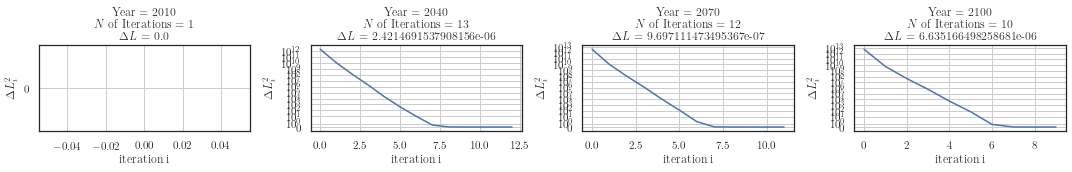

CPU times: user 1min 12s, sys: 952 ms, total: 1min 13s
Wall time: 1min 13s


In [28]:
%%time
m1 = model(name="intermediate, bilateral mig", tol=1e-5, scenario='intermediate')
m1.technology_calib()
m1.calib_migcosts()
m1.fertility()
m1.simulate(report=True, report_from=0, max_iter=50,quickstart=True)

## Minimalist bilateral

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


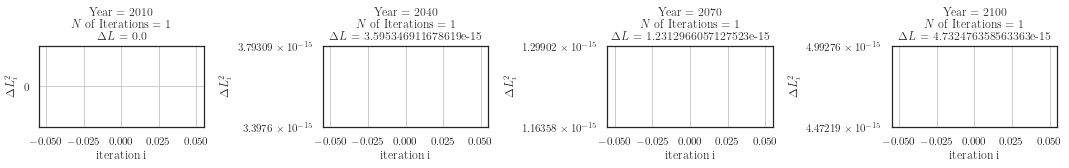

CPU times: user 18.2 s, sys: 766 ms, total: 18.9 s
Wall time: 20.1 s


In [167]:
%%time
m2 = model(name="minimalist, bilateral mig", tol=1e-5, scenario='minimalist')
m2.technology_calib()
m2.calib_migcosts()
m2.fertility()
m2.simulate(report=True, report_from=0, max_iter=50,quickstart=True)

## Maximalist bilateral

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


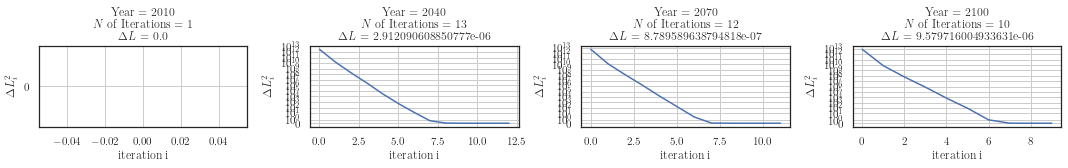

CPU times: user 1min 13s, sys: 735 ms, total: 1min 13s
Wall time: 1min 13s


In [168]:
%%time
m3 = model(name='maximalist, bilateral mig', tol=1e-5, scenario='maximalist')
m3.technology_calib()
m3.calib_migcosts()
m3.fertility()
m3.simulate(report=True, report_from=0, max_iter=50,quickstart=True)

## Intermediate no South

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


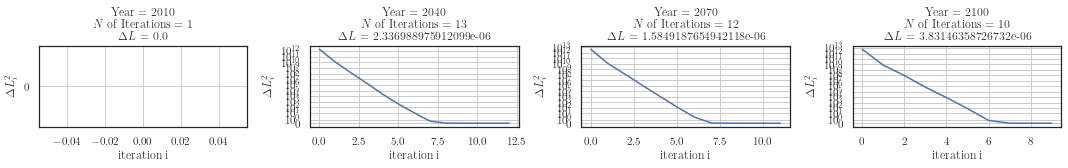

CPU times: user 1min 14s, sys: 756 ms, total: 1min 15s
Wall time: 1min 14s


In [169]:
%%time
m4 = model(name='intermediate no South', tol=1e-5, scenario='intermediate')
m4.technology_calib()
m4.calib_migcosts()
m4.fertility()
m4.simulate(report=True, report_from=0, max_iter=50,quickstart=True,mig_config='no_south')

## Minimalist no South

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


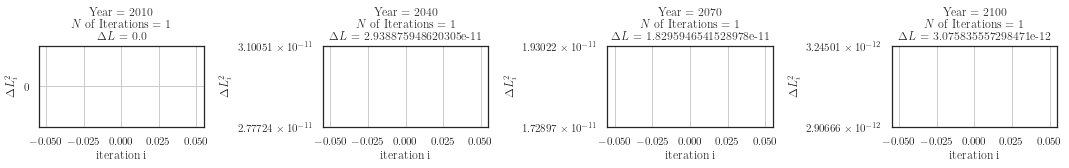

CPU times: user 18.6 s, sys: 754 ms, total: 19.3 s
Wall time: 20.5 s


In [170]:
%%time
m5 = model(name='minimalist no South', tol=1e-5, scenario='minimalist')
m5.technology_calib()
m5.calib_migcosts()
m5.fertility()
m5.simulate(report=True, report_from=0, max_iter=50,quickstart=True,mig_config='no_south')

## Maximalist no South

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


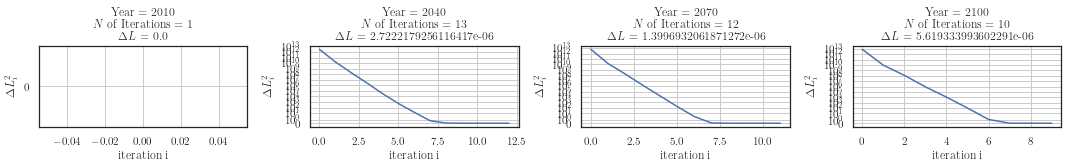

CPU times: user 1min 12s, sys: 792 ms, total: 1min 13s
Wall time: 1min 12s


In [171]:
%%time
m6 = model(name='maximalist no South', tol=1e-5, scenario='maximalist')
m6.technology_calib()
m6.calib_migcosts()
m6.fertility()
m6.simulate(report=True, report_from=0, max_iter=50,quickstart=True,mig_config='no_south')

## Intermediate no North

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


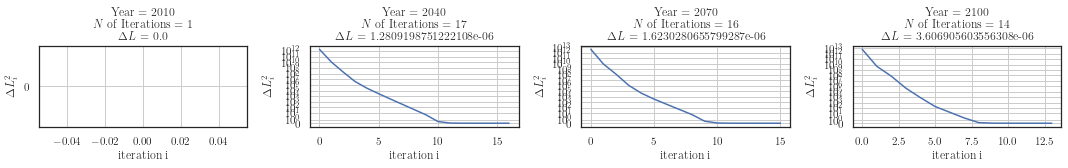

CPU times: user 1min 35s, sys: 870 ms, total: 1min 36s
Wall time: 1min 36s


In [172]:
%%time
m7 = model(name='intermediate no North', tol=1e-5, scenario='intermediate')
m7.technology_calib()
m7.calib_migcosts()
m7.fertility()
m7.simulate(report=True, report_from=0, max_iter=50,quickstart=True,mig_config='no_north')

## Minimalist no North

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


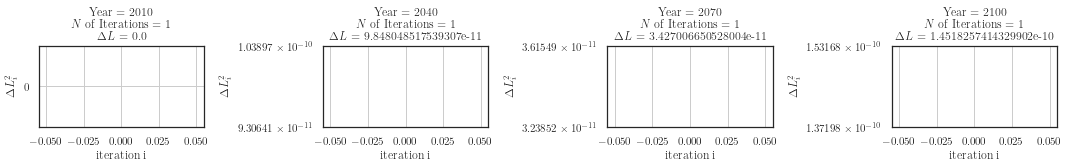

CPU times: user 20.2 s, sys: 733 ms, total: 21 s
Wall time: 22.4 s


In [173]:
%%time
m8 = model(name='minimalist no North', tol=1e-5, scenario='minimalist')
m8.technology_calib()
m8.calib_migcosts()
m8.fertility()
m8.simulate(report=True, report_from=0, max_iter=50,quickstart=True,mig_config='no_north')

## Maximalist no North

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


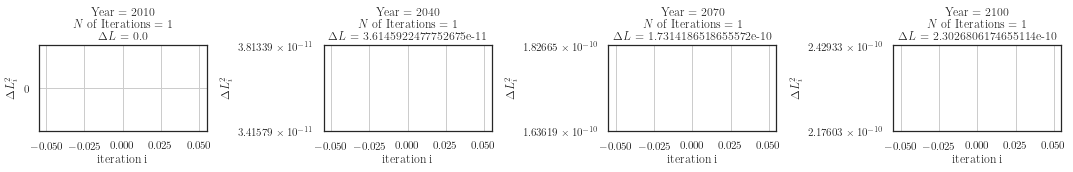

CPU times: user 18.4 s, sys: 751 ms, total: 19.1 s
Wall time: 20.4 s


In [29]:
%%time
m9 = model(name='maximalist no North', tol=1e-5, scenario='maximalist')
m9.technology_calib()
m9.calib_migcosts()
m9.fertility()
m9.simulate(report=True, report_from=0, max_iter=50,quickstart=True,mig_config='no_north')

## Intermediate compensation for flooding

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


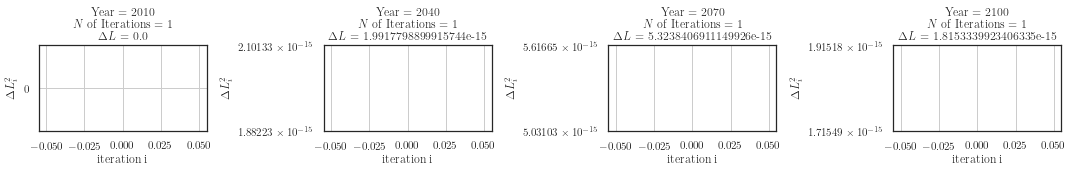

CPU times: user 18.7 s, sys: 758 ms, total: 19.5 s
Wall time: 20.1 s


In [30]:
%%time
m10 = model(name="intermediate, comp for forced displ", tol=1e-5, scenario='intermediate',χ={'d': 0.0, 'f': 0.0})
m10.technology_calib()
m10.calib_migcosts()
m10.fertility()
m10.simulate(report=True, report_from=0, max_iter=50,quickstart=True)

## Intermediate proportional increase

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


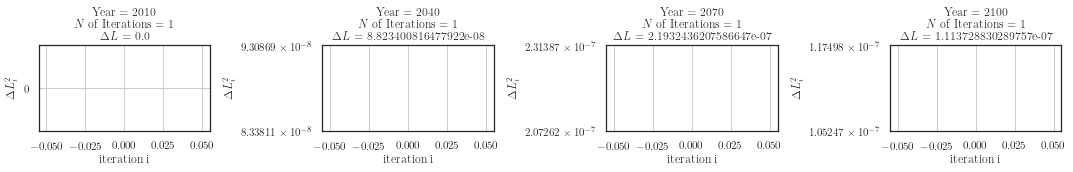

CPU times: user 18.1 s, sys: 925 ms, total: 19 s
Wall time: 20.3 s


In [34]:
%%time
m11 = model(name="intermediate proportional increase", tol=1e-5, scenario='intermediate')
m11.technology_calib()
m11.calib_migcosts()
m11.fertility()
m11.simulate(report=True, report_from=0, max_iter=50,quickstart=True,mig_config='proporional_increase')

## Intermediate proportional decrease

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


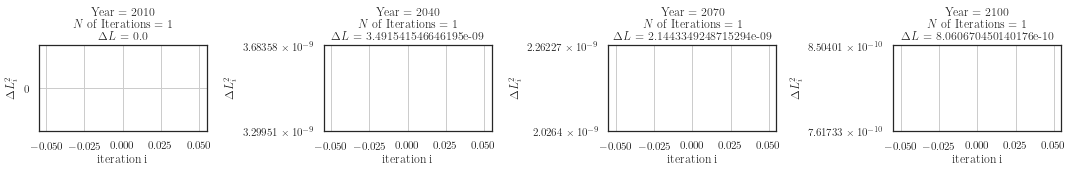

CPU times: user 17.9 s, sys: 244 ms, total: 18.2 s
Wall time: 20.3 s


In [33]:
%%time
m12 = model(name="intermediate proportional decrease", tol=1e-5, scenario='intermediate')
m12.technology_calib()
m12.calib_migcosts()
m12.fertility()
m12.simulate(report=True, report_from=0, max_iter=50,quickstart=True,mig_config='proporional_decrease')

## Intermediate no international

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


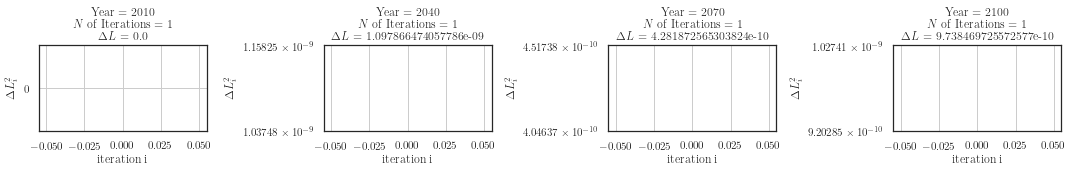

CPU times: user 17.8 s, sys: 746 ms, total: 18.5 s
Wall time: 19.7 s


In [31]:
%%time
m13 = model(name="intermediate no international mig", tol=1e-5, scenario='intermediate')
m13.technology_calib()
m13.calib_migcosts()
m13.fertility()
m13.simulate(report=True, report_from=0, max_iter=50,quickstart=True,mig_config='no_international')

## Intermediate no internal

/home/scheewel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


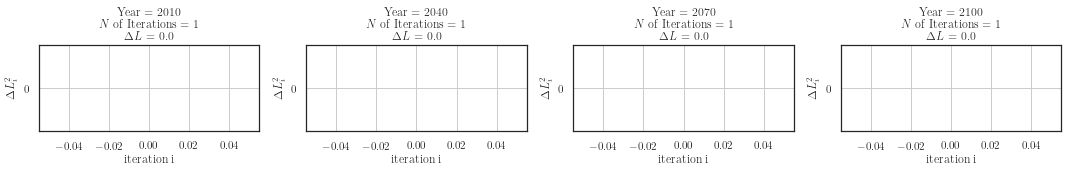

CPU times: user 18.7 s, sys: 669 ms, total: 19.4 s
Wall time: 18.4 s


In [32]:
%%time
m14 = model(name="intermediate no internal mig", tol=1e-5, scenario='intermediate')
m14.technology_calib()
m14.calib_migcosts()
m14.fertility()
m14.simulate(report=True, report_from=0, max_iter=50,quickstart=True,mig_config='no_internal')

## Intermediate no migration

In [ ]:
%%time
m15 = model(name="intermediate no mig", tol=1e-5, scenario='intermediate')
m15.technology_calib()
m15.calib_migcosts()
m15.fertility()
m15.simulate(report=True, report_from=0, max_iter=50,quickstart=True,mig_config='no')

## Intermediate no flooding

In [ ]:
%%time
m16 = model(name="intermediate_no_sea_rise", tol=1e-5, scenario='intermediate')
m16.ω = 0 * m16.ω # No sea-level rise
m16.technology_calib()
m16.calib_migcosts()
m16.fertility()
m16.simulate(report=True, report_from=0, max_iter=50,quickstart=True)

## Minimalist no flooding

In [ ]:
%%time
m17 = model(name="minimalist_no_sea_rise", tol=1e-5, scenario='minimalist')
m17.ω = 0 * m17.ω # No sea-level rise
m17.technology_calib()
m17.calib_migcosts()
m17.fertility()
m17.simulate(report=True, report_from=0, max_iter=50,quickstart=True)

## Maximalist no flooding

In [ ]:
%%time
m18 = model(name="maximalist_no_sea_rise", tol=1e-5, scenario='maximalist')
m18.ω = 0 * m18.ω # No sea-level rise
m18.technology_calib()
m18.calib_migcosts()
m18.fertility()
m18.simulate(report=True, report_from=0, max_iter=50,quickstart=True)

# Outputs

## Parameterization

### TFP changes
`Frédéric:` Hendrik: we have to find how to represent TFP changes differently from
BDDM?

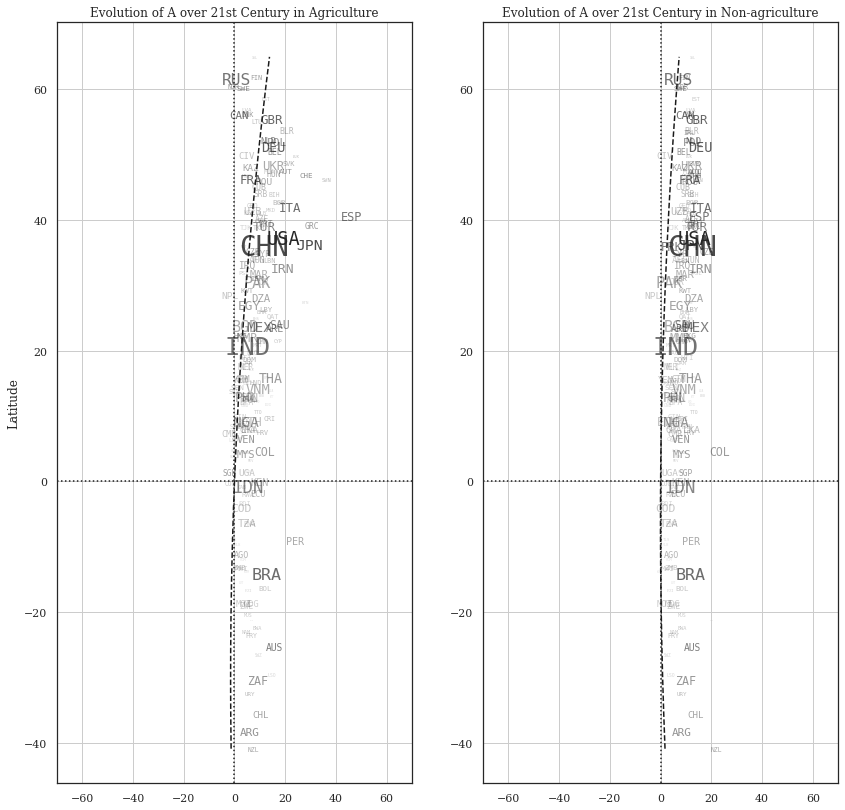

In [528]:
m = m1
var = 'A'
df = (10*(m.__dict__[var].xs(2100,1,1)-m.__dict__[var].xs(2010,1,1))/m.__dict__[var].xs(2010,1,1))
df['latitude'] = m.latitude

fig = plt.figure(figsize=(14,14))
sector = {'a': 'Agriculture',
          'n': 'Non-agriculture'}
count = 1
for r in R:
    plt.subplot(1, 2, count)
    x = df[r]
    y = df.latitude
    params = np.polyfit(y,x,2)
    y2 = np.linspace(min(y),max(y),1000)
    x2 = params[0] + params[1] * y2 + params[0] * y2**2
    size = (m.L.xs(2010,1,2).sum(1)/m.L.xs(2010,1,2).sum(1).sum())**(1/4)
    gdppc = (m.w.xs(2010,1,2) * m.L.xs(2010,1,2)).sum(1)
    plt.scatter(x,y,s=0)
    plt.plot(x2,y2,color='k',linestyle='dashed',label=m.name)
    for country in df.index:
        plt.annotate(m.iso.loc[country],(x.loc[country],y.loc[country]),
                 fontsize=40*size.loc[country],alpha=((gdppc/gdppc.max())**(1/5)).loc[country],
                 ha='center',va='center',**hfont)
    plt.axvline(0,color='k',linestyle='dotted')
    plt.axhline(0,color='k',linestyle='dotted')
    plt.xlim([-70,70])
    #plt.xlabel('$(A_{r,2100}-A_{r,2010})/A_{r,2010}$')
    plt.title('Evolution of %s over 21st Century in %s' % (var,sector[r]))
    plt.grid()
    if count == 1:
        plt.ylabel('Latitude')
    #plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),ncol=1,handlelength=4)
    count += 1
plt.show()
   


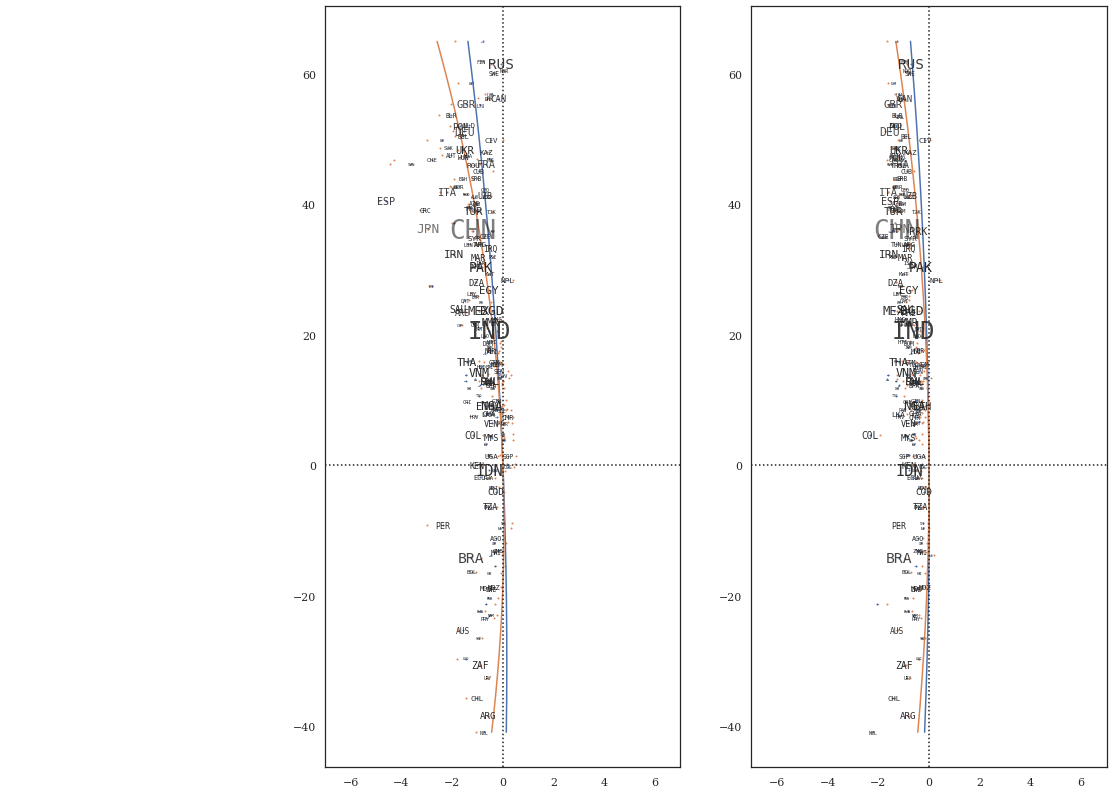

In [454]:
DeltaD = (m1.A.xs(2010,1,1)-m1.A.xs(2100,1,1))/m1.A.xs(2010,1,1)
DeltaD['latitude'] = m1.latitude
DeltaD_max = (m3.A.xs(2010,1,1)-m3.A.xs(2100,1,1))/m3.A.xs(2010,1,1)
DeltaD_max['latitude'] = m3.latitude

hfont = {'fontname':'monospace'}

fig = plt.figure(figsize=(14,14))
count = 1
for r in R:
    plt.subplot(1, 2, count)
    x = DeltaD[r]
    y = DeltaD.latitude
    params = np.polyfit(y,x,2)
    y2 = np.linspace(min(y),max(y),1000)
    x2 = params[0] + params[1] * y2 + params[0] * y2**2
    count += 1
    size = (m1.L.xs(2010,1,2).sum(1)/m1.L.xs(2010,1,2).sum(1).sum())**(1/3.5)
    gdppc = (m1.w.xs(2010,1,2) * m1.L.xs(2010,1,2)).sum(1)
    plt.scatter(x,y,s=1)
    plt.plot(x2,y2)
    for country in DeltaD.index:
        plt.annotate(m1.iso.loc[country],(DeltaD[r].loc[country],DeltaD.latitude.loc[country]),
                     fontsize=40*size.loc[country],alpha=(1-(gdppc/gdppc.max())).loc[country],
                     ha='center',va='center',**hfont)
    x_max = DeltaD_max[r]
    y_max = DeltaD_max.latitude
    params_max = np.polyfit(y_max,x_max,2)
    y_max_2 = np.linspace(min(y_max),max(y_max),1000)
    x_max_2 = params_max[0] + params_max[1] * y_max_2 + params_max[0] * y_max_2**2
    plt.scatter(x_max,y_max,s=1)
    plt.plot(x_max_2,y_max_2)
    plt.axvline(0,color='k',linestyle='dotted')
    plt.axhline(0,color='k',linestyle='dotted')
    plt.xlim([-7,7])
plt.show()

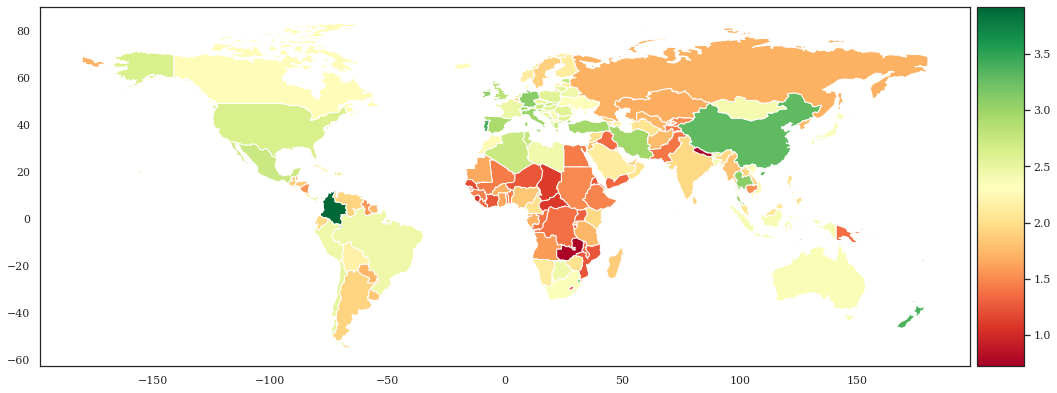

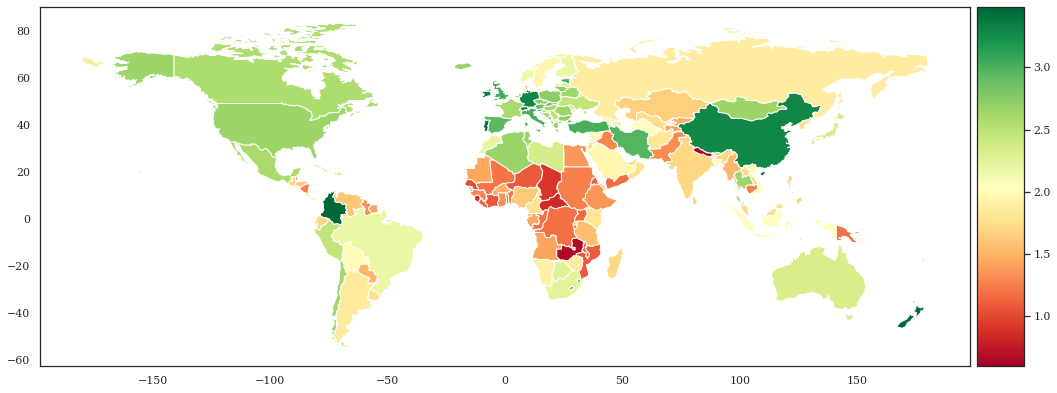

In [539]:
for m in [m1,m3]:
    A = m.A
    Lr = m.L.unstack().reset_index().groupby(['r','t','Country']).sum()[0].unstack([0,1])
    L = m.L.unstack().reset_index().groupby(['t','Country']).sum()[0].unstack().T
    L = pd.concat([L,L],1,keys=['a','n'],names=['r','t'])

    TFP = (A*(Lr/L)).unstack().reset_index().groupby(['t','Country']).sum().unstack(0)[0][[2010,2100]]
    TFP['ratio'] = TFP[2100]/TFP[2010]
    TFP = TFP.join(m.iso)
    TFP = TFP.sort_values('ratio')
    stats = round(TFP.ratio.describe(),4)

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    width = 15
    fig, ax = plt.subplots(figsize=(width, 3/8*width))
    ax.set_aspect('equal')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    m.shapes.join(TFP.ratio).plot('ratio', ax=ax, legend=True, cax=cax,cmap='RdYlGn')
    #plt.title('Pop. Weighted TFP ratio: 2100/2010')
    display(HTML('<b>%s $(\mu = %s$, $\sigma =  %s)$</b>' % (m.name,str(stats['mean']),str(stats['mean']))))
    fig.savefig('graphs/maps/TFP2100over2010_%s.pdf' %m.name)
    plt.tight_layout()

    plt.show()

### Theta

`Frédéric:` Hendrik: we have to find how to represent Theta differently (map?)

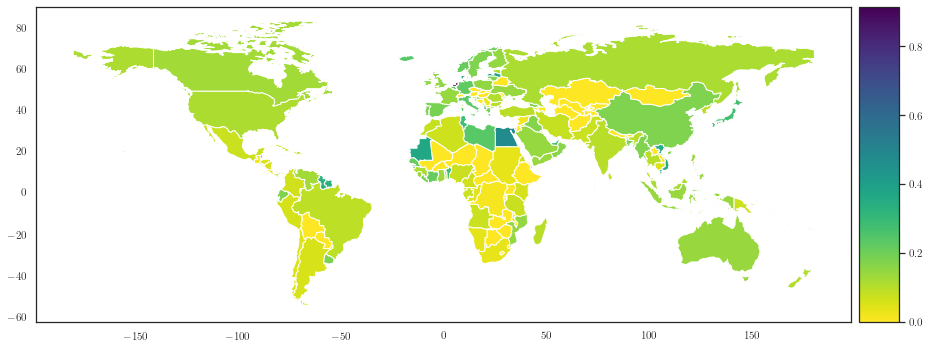

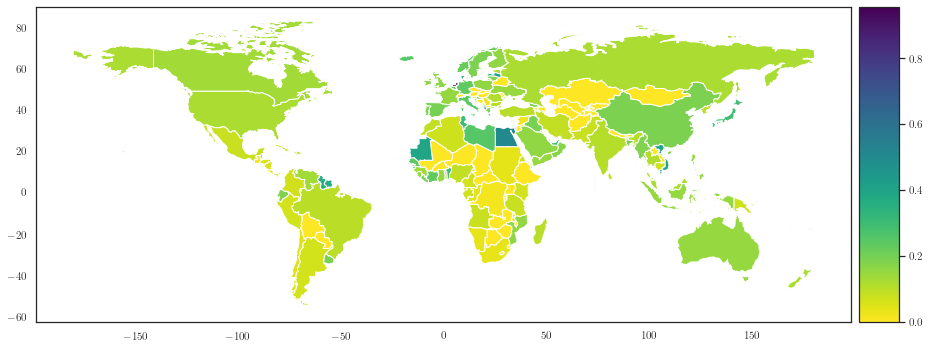

In [170]:
for m in [m1,m3]:
    N = m.N.unstack().reset_index().groupby(['r','t','Country']).sum().unstack([0,1])[0].xs(2100,1,1)
    ω = m.ω.xs(2100,1,1)
    df = pd.DataFrame((N * ω).sum(1)/N.sum(1))
    stats = round(df[0].describe(),4)
    df[0] = (df[0])**(1/2)

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    fig, ax = plt.subplots(figsize=(15, 5))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    m.shapes.join(df).plot(0,figsize=(20,10), ax=ax, legend=True, cax=cax,cmap='viridis_r')
    #plt.title('Share of flooded people: 2100')
    display(HTML('<b>%s $(\mu = %s$, $\sigma =  %s)$</b>' % (m.name,str(stats['mean']),str(stats['mean']))))
    plt.tight_layout()
    plt.show()
    fig.savefig('graphs/maps/flooding_%s.pdf' %m.name)


In [955]:
def tileplot(m=m1,gridsize=(30,30),figsize=(25,25),boxscale=2.5, asp_ratio = figsize[1]/figsize[0]):
    width  = 0.01*boxscale*(max(m.longitude) - min(m.longitude))
    height = 0.01*boxscale*(max(m.latitude) - min(m.latitude))*asp_ratio
    x = np.linspace(min(m.longitude),max(m.longitude),gridsize[0])
    y = np.linspace(min(m.latitude),max(m.latitude),gridsize[0])
    df = pd.DataFrame([m.longitude,m.latitude,m.iso,m.shapes.geometry.area]).T
    df = df.sort_values(['longitude','latitude'])
    xy = np.array(list(itertools.product(x, y)))
    minima = []
    
    for i in df.index:
        lonlat = (df.longitude.loc[i],df.latitude.loc[i])
        minima.append(min(((lonlat-xy)**2).sum(1)))

    df['minima'] = minima
    
    df = df.sort_values(['minima'])
    
    for i in df.index:
        lonlat = (df.longitude.loc[i],df.latitude.loc[i])
        arg = np.where(((lonlat-xy)**2).sum(1) == min(((lonlat-xy)**2).sum(1)))
        df['longitude'].loc[i] = xy[arg][0][0]
        df['latitude'].loc[i]  = xy[arg][0][1]
        xy = np.delete(xy, arg, 0)
        
    df = df.sort_index()


    N = m.N.unstack().reset_index().groupby(['r','t','Country']).sum().unstack([1,0])[0][2100]
    ω = m.ω.xs(2100,1,1)
    flooded = (N * ω).sum(1)/N.sum(1)
    df['ω'] = flooded

    #df = df.set_index('iso3')
    fig,ax = plt.subplots(1,figsize=figsize)
    plt.scatter(df.longitude,df.latitude,marker='o',s=0,color='lightgray')

    for i in df.index:
        ax.add_patch(patches.Rectangle((df.loc[i].longitude-width/2,df.loc[i].latitude-height/2),width,height,linewidth=0,edgecolor=None,facecolor='lightgray'))
        ax.add_patch(patches.Rectangle((df.loc[i].longitude-width/2,df.loc[i].latitude-height/2),width,height*df['ω'].loc[i],facecolor='blue'))
        plt.annotate(df.iso3.loc[i],(df.loc[i].longitude,df.loc[i].latitude),ha='center',va='center',color='black',fontsize=10,**hfont)
        #plt.annotate(m.iso.loc[i],(m.longitude.loc[i],m.latitude.loc[i]),ha='center',va='center',color='black',fontsize=10,**hfont)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Share of people in flooded areas \n Sea-level rise: + 1.1 meters (blue) vs. +1.3 meters (red) by 2100')

    plt.show()
    fig.savefig('graphs/tile_%sx%s.pdf' %(str(gridsize),str(gridsize)))
    return(df)

In [956]:
m1.longitude = m1.shapes.geometry.centroid.x
m1.latitude = m1.shapes.geometry.centroid.y

m1.longitude.name = 'longitude'
m1.latitude.name = 'latitude'

/home/scheewel/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


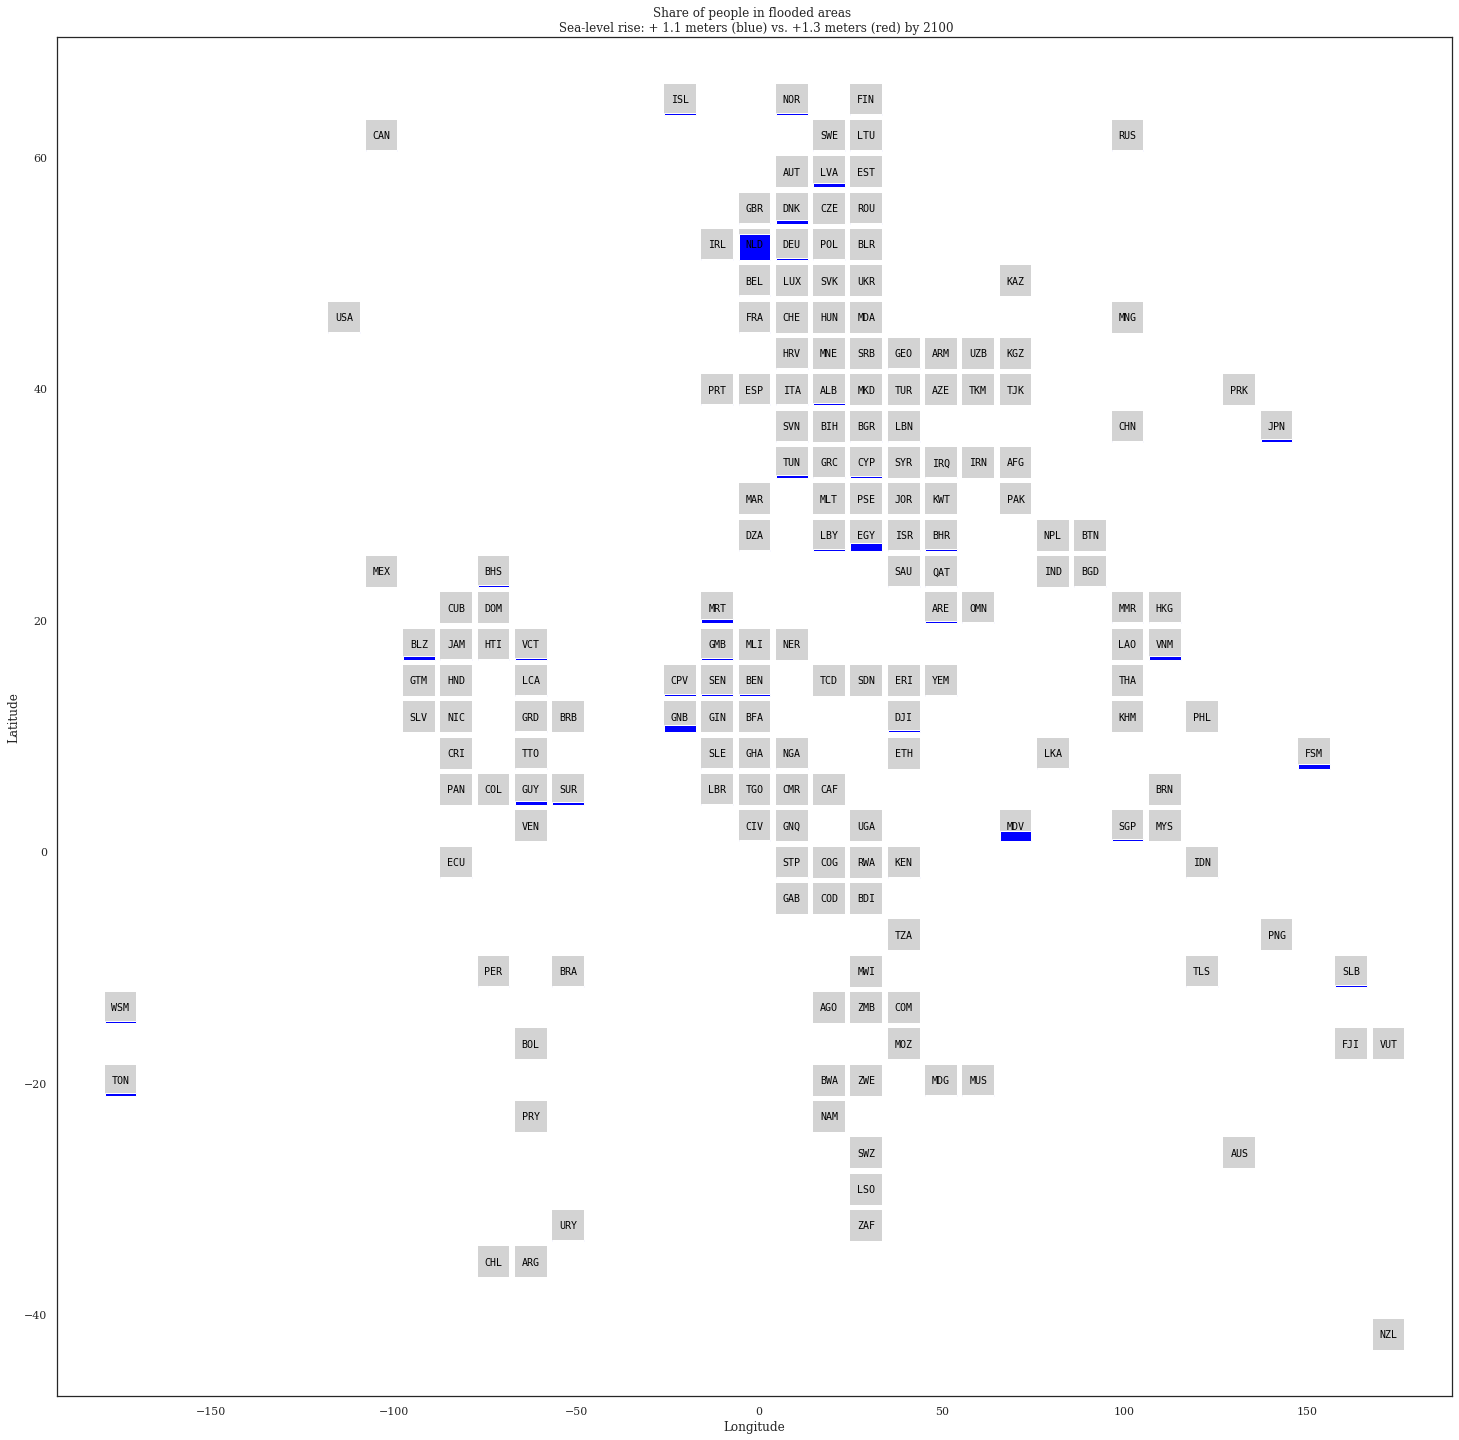

In [957]:
a = tileplot(gridsize=(35,35))

## Result section

### Constant moving costs : Comparison between climate scenarios (i.e. climate migrants)

`Frédéric:` Hendrik: (1) I’d start with your two graphs 4a-4b (I’d put flashy colors for
migration to North (yellow) and to South (red), then interregional in black
and local in grey + one graph per line using full width of the page);

In [188]:
def stackplot(mod_int_or_max,mod_min,drop=None,save=False,name='default.pdf',title=None,ylim=None):
    matrix = (mod_int_or_max.out_migrant_world_stock()-mod_min.out_migrant_world_stock())
    matrix['Type'] = matrix.index
    matrix['Type'] = matrix.Type.str.split('-').apply(lambda x: x[-1])
    matrix = matrix.groupby('Type').sum()
    h = cycle(['','/','\\','|||'])
    if drop != None:
        mtx = matrix.drop(drop,0).sort_values(by=2040,ascending=False).T
    else:
        mtx = matrix.sort_values(by=2040,ascending=False).T
    cols = list(mtx)
    colordict = {
                 'Local': 'gray', 
                 'Interregional': 'black', 
                 'North':'yellow', 
                 'South':'red'
                }
    x = list(mtx.index)
    y = []
    hatches = []
    fig = plt.figure(figsize=[8,5])
    colors = []
    for col in cols:
        y = y + [list(mtx[col])]
        hatches = hatches + [next(h)]
        colors = colors + [colordict[col]]
    stacks = plt.stackplot(x,np.array(y),labels=cols,colors=colors,lw=1)
    #for stack in stacks:
    #    stack.set_hatch(next(h))
    plt.xticks(x)
    plt.ylabel('in Mio.')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),ncol=4)
    plt.title(title)
    plt.grid()
    plt.tight_layout()
    plt.ylim([0,ylim])
    plt.show()
    #display(mtx)
    if save != False:
        fig.savefig('graphs/stackplots/'+name)


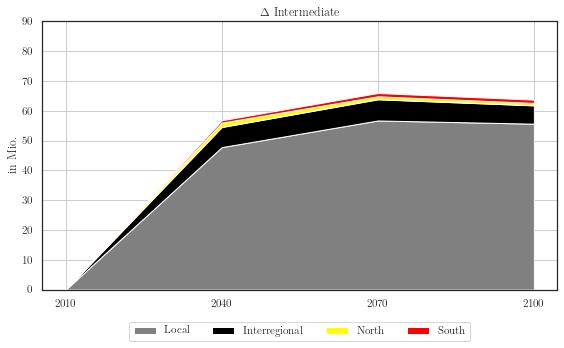

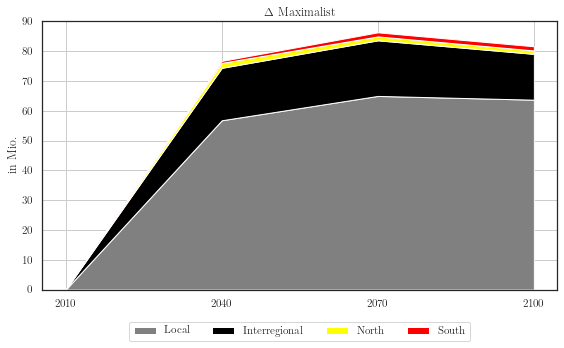

In [464]:
stackplot(m1,m2,save=True,name='int_min_full.pdf',title='$\Delta$ Intermediate',ylim=90)
stackplot(m3,m2,save=True,name='max_min_full.pdf',title='$\Delta$ Maximalist',ylim=90)

`Frédéric`: (2) Tables 4 is fine but I’d add a column with the sum over the century + a decomposition
by origin (we need to iterate on this table to make sure it is readable =⇒ 2
figures (one page) + 1 table (one page)


#### World stock of climate migrant by type (local, interregional, South-South, South-North) for 2 scenarios

In [463]:
minim = m2.out_migrant_world_stock()
inter = round(m1.out_migrant_world_stock()-minim,4)
maxim = round(m3.out_migrant_world_stock()-minim,4)

tab = pd.concat([inter,maxim],0,keys=['$\Delta$ Intermediate','$\Delta$ Maximalist'])
tab.unstack(0).swaplevel(0,0,1).T.sort_index().T

t                              2010                                      2040  \
              $\Delta$ Intermediate $\Delta$ Maximalist $\Delta$ Intermediate   
Local                           0.0                 0.0               47.8005   
Interregional                   0.0                 0.0                6.7538   
North-North                     0.0                 0.0                0.7403   
North-South                     0.0                 0.0                0.0538   
South-North                     0.0                 0.0                0.7270   
South-South                     0.0                 0.0                0.7363   

t                                                  2070                      \
              $\Delta$ Maximalist $\Delta$ Intermediate $\Delta$ Maximalist   
Local                     56.8146               56.7461             64.9844   
Interregional             17.5951                7.1133             18.6618   
North-North                0.9813                0.3812              0.4934   
North-South                0.0703                0.0241              0.0300   
South-North                0.6767                0.6239              0.8188   
South-South                0.5971                1.0717              1.3420   

t                              2100                      
              $\Delta$ Intermediate $\Delta$ Maximalist  
Local                       55.6660             63.7226  
Interregional                6.1477             15.3754  
North-North                  0.2176              0.2799  
North-South                  0.0136              0.0168  
South-North                  0.5977              0.8609  
South-South                  1.1003              1.3877

#### Skill structure of climate migration
`Frédéric:` Hendrik: can you computed the share of college grads in climate migration:
same table as in previous section =⇒ 1 table (one page)

In [461]:
def out_mig_world_stock_by_skill(m,skill='all'):
    M = m.M.reset_index()
    M.Country = M.Country.replace(m.OECD.replace([0,1],['South','North']))
    M.Destination = M.Destination.replace(m.OECD.replace([0,1],['South','North']))
    M['Type'] = np.where(M.Type == 'International', M.Country+'-'+M.Destination,M.Type)
    tab = M.groupby(['Type','s','t']).sum().unstack().drop('Stayers',0)[0]
    if (skill == 'l') | (skill == 'h'):
        return(tab.xs(skill,0,1))
    else:
        ALL_migrants = tab.reset_index().groupby(['Type']).sum()
        return(ALL_migrants)

In [611]:
HS_int = out_mig_world_stock_by_skill(m1,'h')
HS_min = out_mig_world_stock_by_skill(m2,'h')
HS_max = out_mig_world_stock_by_skill(m3,'h')
ALL_int = out_mig_world_stock_by_skill(m1)
ALL_min = out_mig_world_stock_by_skill(m2)
ALL_max = out_mig_world_stock_by_skill(m3)

In [451]:
def pie_plots(table,save_name=None):
    fig = plt.figure(figsize=[10,15])
    col = 1
    plt.subplots_adjust(top=0.8,wspace=0.8)
    row = 1
    for Type in table.index:
        for year in list(table):
            plt.subplot(5, 3, col)
            if year == 2040:
                plt.ylabel(Type,fontsize=20)
            if row == 1:
                plt.title(year,fontsize=20,pad=15)
            col += 1
            plt.pie([table[year][Type],1-table[year][Type]],labels=['HS','LS'],startangle=90,colors=['#CCCCCC','#999999'],counterclock=False)
        row += 1
    plt.tight_layout()
    plt.show()
    if save_name != None:
        fig.savefig(save_name)


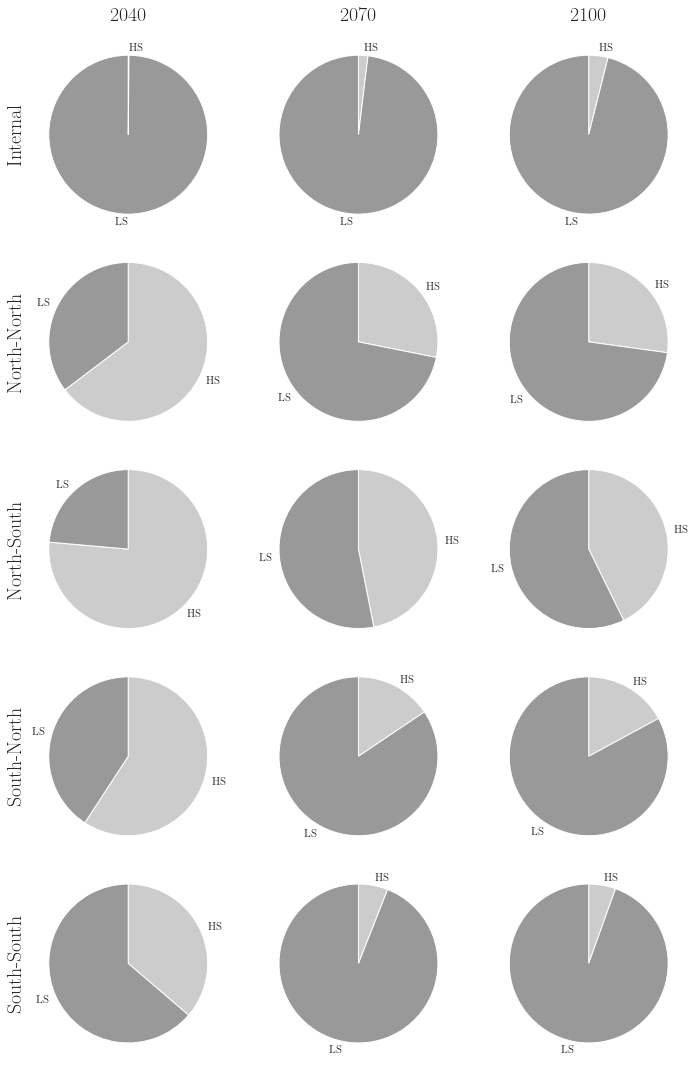

In [452]:

pie_plots(((HS_int-HS_min)/(ALL_int-ALL_min)).drop([2010],1),save_name='graphs/pies/HS_share_in_clc_mig.pdf')

In [621]:
tab_min = (HS_int/ALL_int).drop([2010],1)

In [622]:
tab_int = ((HS_int-HS_min)/(ALL_int-ALL_min)).drop([2010],1)

In [623]:
tab_max = ((HS_max-HS_min)/(ALL_max-ALL_min)).drop([2010],1)

In [627]:
tab = pd.concat([tab_min,tab_int,tab_max],0,keys=['Minimalist','$\Delta$ Intermediate','$\Delta$ Maximalist'])

In [628]:
tab

t                                      2040      2070      2100
                      Type                                     
Minimalist            Internal     0.080777  0.087718  0.084399
                      North-North  0.613964  0.625477  0.658808
                      North-South  0.783374  0.796350  0.817215
                      South-North  0.604491  0.642298  0.670990
                      South-South  0.294962  0.302781  0.295641
$\Delta$ Intermediate Internal     0.001554  0.019188  0.039156
                      North-North  0.646828  0.281436  0.271774
                      North-South  0.763996  0.469056  0.427367
                      South-North  0.592071  0.155756  0.170929
                      South-South  0.362644  0.059820  0.054852
$\Delta$ Maximalist   Internal     0.024911  0.037663  0.052033
                      North-North  0.617410  0.249726  0.238129
                      North-South  0.741070  0.416844  0.365308
                      South-North  0.630710  0.226118  0.313038
                      South-South  0.478982  0.096266  0.119336

In [632]:
print(tab.to_latex(header=True,index=True,bold_rows=True,multicolumn=True,escape=False,multirow=True))

\begin{tabular}{llrrr}
\toprule
                    & \textbf{t} &      2040 &      2070 &      2100 \\
{} & \textbf{Type} &           &           &           \\
\midrule
\multirow{5}{*}{\textbf{Minimalist}} & \textbf{Internal} &  0.080777 &  0.087718 &  0.084399 \\
                    & \textbf{North-North} &  0.613964 &  0.625477 &  0.658808 \\
                    & \textbf{North-South} &  0.783374 &  0.796350 &  0.817215 \\
                    & \textbf{South-North} &  0.604491 &  0.642298 &  0.670990 \\
                    & \textbf{South-South} &  0.294962 &  0.302781 &  0.295641 \\
\cline{1-5}
\multirow{5}{*}{\textbf{$\Delta$ Intermediate}} & \textbf{Internal} &  0.001554 &  0.019188 &  0.039156 \\
                    & \textbf{North-North} &  0.646828 &  0.281436 &  0.271774 \\
                    & \textbf{North-South} &  0.763996 &  0.469056 &  0.427367 \\
                    & \textbf{South-North} &  0.592071 &  0.155756 &  0.170929 \\
                    & \textbf{South-Sout

#### Sensibility to sea level
`Frédéric:` In line with Rigaud et al.
(2018), we assume that SLR reaches 2m in 2040. We then prolong the trend and predict
2.4m in 2070 and 2.7m in 2100.
Hendrik: can you simulate this? Michal computed the Theta for this scenario.
We simply need a graph comparable to your current graph 4a. Note that we
could also simulate a scenario without sea level rise. =⇒ 1 or 2 figure(s)

**WHERE CAN I FIND THE DATA?**

#### Inequality and poverty responses
`Frédéric:` Hendrik: can you adjust the comments below; the Appendix can include the
macro projections (your last table)

In [595]:
def agg_ef_table(m,on='bddm'):
    tbl = out_world_aggregates(m,on).unstack(-2)[[2040,2070,2100]].swaplevel(1,0,1).stack().unstack().sort_index(0)
    return(tbl)

a = agg_ef_table(m2)
b = agg_ef_table(m1)-agg_ef_table(m2)
c = agg_ef_table(m3)-agg_ef_table(m2)
tab = pd.concat([a,b,c],keys=['Minimalist','$\Delta$ Intermediate','$\Delta$ Maximalist'],axis=0).swaplevel(0,1,0)
tab = tab.sort_index(axis=0,level=[0,1],ascending=[True,False])

In [591]:
int_min = (m1.out_world_aggregates()-m2.out_world_aggregates()).drop(2010,1).T.reset_index()
max_min = (m3.out_world_aggregates()-m2.out_world_aggregates()).drop(2010,1).T.reset_index()
minimal = (m2.out_world_aggregates()).drop(2010,1).T.reset_index()
int_min['bddm'] = 'World'
int_min[''] = '$\Delta$ Intermediate'
int_min = int_min.set_index(['bddm','t','']).unstack(1)
max_min['bddm'] = 'World'
max_min[''] = '$\Delta$ Maximalist'
max_min = max_min.set_index(['bddm','t','']).unstack(1)
minimal['bddm'] = 'World'
minimal[''] = 'Minimalist'
minimal = minimal.set_index(['bddm','t','']).unstack(1)

In [592]:
tab = tab.append(pd.concat([minimal,max_min,int_min],0))

In [593]:
tab

GDP in 10e9 \$US                      \
t                                       2040      2070      2100   
bddm                                                               
CARE  Minimalist                      804.85    917.60    968.28   
      $\Delta$ Maximalist             -47.28    -87.74   -118.45   
      $\Delta$ Intermediate           -19.87    -42.30    -58.82   
EAP   Minimalist                     1554.33   1600.54   1485.76   
      $\Delta$ Maximalist            -145.36   -153.21   -152.43   
      $\Delta$ Intermediate           -72.85    -79.89    -80.10   
LAC   Minimalist                      968.73   1040.39   1007.23   
      $\Delta$ Maximalist            -158.00   -182.93   -182.26   
      $\Delta$ Intermediate           -70.11    -84.56    -85.07   
MENA  Minimalist                      788.49    975.10   1046.18   
      $\Delta$ Maximalist             -67.27   -103.84   -116.20   
      $\Delta$ Intermediate           -27.17    -48.42    -55.09   
OECD  Minimalist                     8816.83   8523.96   8145.55   
      $\Delta$ Maximalist             648.29    482.67    455.47   
      $\Delta$ Intermediate           370.82    257.74    242.94   
SSA   Minimalist                      420.67    787.98   1288.52   
      $\Delta$ Maximalist             -68.95   -146.27   -263.12   
      $\Delta$ Intermediate           -31.66    -70.30   -127.60   
World Minimalist                    13353.90  13845.58  13941.51   
      $\Delta$ Maximalist             161.43   -191.33   -376.97   
      $\Delta$ Intermediate           149.16    -67.73   -163.72   

                            GDP per Worker                        \
t                                     2040       2070       2100   
bddm                                                               
CARE  Minimalist                   7321.96    8322.87   10110.32   
      $\Delta$ Maximalist          -429.01    -781.60   -1197.45   
      $\Delta$ Intermediate        -179.60    -375.62    -593.85   
EAP   Minimalist                  15967.05   19280.44   22828.13   
      $\Delta$ Maximalist         -1489.43   -1789.09   -2178.08   
      $\Delta$ Intermediate        -743.49    -927.04   -1138.12   
LAC   Minimalist                  39675.49   47079.89   56238.83   
      $\Delta$ Maximalist         -6477.85   -8270.34  -10140.23   
      $\Delta$ Intermediate       -2867.02   -3812.19   -4729.24   
MENA  Minimalist                  27987.23   30887.19   35732.71   
      $\Delta$ Maximalist         -2363.14   -3233.03   -3852.72   
      $\Delta$ Intermediate        -952.00   -1473.39   -1752.48   
OECD  Minimalist                 158378.13  186099.66  219284.35   
      $\Delta$ Maximalist         11460.26   10504.06   12239.12   
      $\Delta$ Intermediate        6461.76    5610.66    6583.29   
SSA   Minimalist                   7198.51    7542.34    7567.62   
      $\Delta$ Maximalist         -1180.36   -1350.26   -1417.83   
      $\Delta$ Intermediate        -541.53    -653.38    -699.11   
World Minimalist                  35708.80   34857.06   33557.03   
      $\Delta$ Maximalist           431.66    -362.01    -543.00   
      $\Delta$ Intermediate         398.86    -114.94    -245.42   

                            HS Share in \%               Population in 10e6  \
t                                     2040   2070   2100               2040   
bddm                                                                          
CARE  Minimalist                     17.76  20.85  25.05             109.92   
      $\Delta$ Maximalist             0.00   0.04   0.17              -0.01   
      $\Delta$ Intermediate           0.00  -0.03   0.01              -0.02   
EAP   Minimalist                     15.99  21.41  27.18              97.35   
      $\Delta$ Maximalist            -0.02  -0.06   0.06              -0.03   
      $\Delta$ Intermediate          -0.02  -0.13  -0.13              -0.04   
LAC   Minimalist                     31.96  37.17  

In [610]:
#Tab Output
#HTML(tab.to_latex(header=True,index=True,bold_rows=True,multicolumn=True,multirow = True,escape=False,))

#### DWorld distribution of income~/DWorld dist. of utility (accounting for 1-x)~ (in the 2 scenarios)

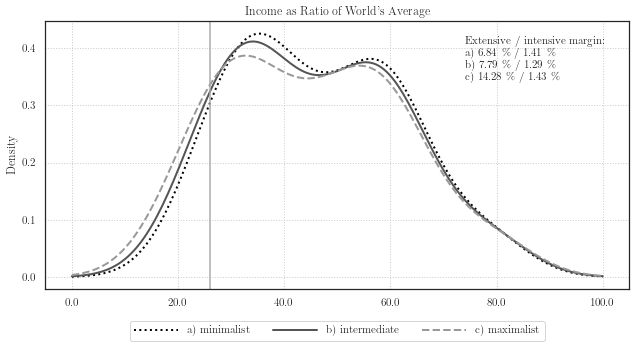

In [69]:
m2.out_distplot([m1,m3],text=True,save=True,cols=3,save_name='Fig7.pdf')

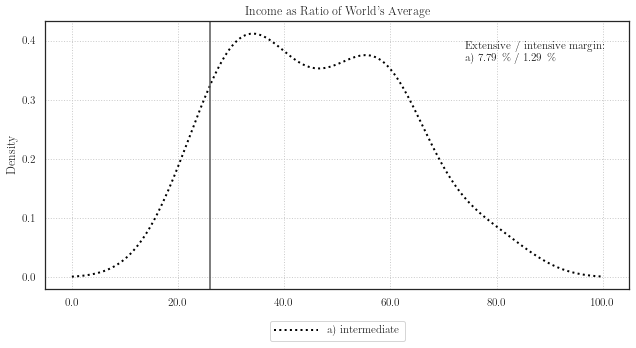

In [70]:
m1.out_distplot(text=True)

### Role of migration policies
`Frédéric` Hendrik: we should add the various closed-border and openness variants here,
focusing only on the world distribution and poverty implications =⇒ 2 figures
(one page) (one with Moderate + closed-border variants, one with openness variants) comparable to the figures above

#### Changes in mover stocks by region of origin w.r.t. Minimalist (one graph per region, local, intern, to S, to N)

##### Changes in mover stocks by region of destin. w.r.t. Minimalist (one graph per region, local, intern, from S, from N)

### Effect of migration policies (closed borders vs same relative change in (1-x) for Urb, mig to S, mig to N)

### In the 3 scenarios: DWorld distribution of income~/DWorld dist. of utility (accounting for 1-x)~

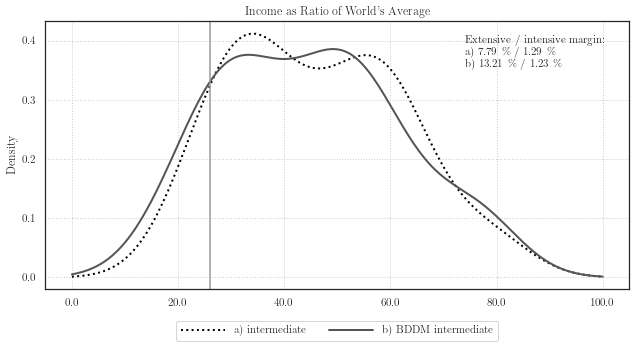

In [72]:
m1.out_distplot([m0],text=True,save=True,save_name='BDSvsBDDM.pdf',cols=2)

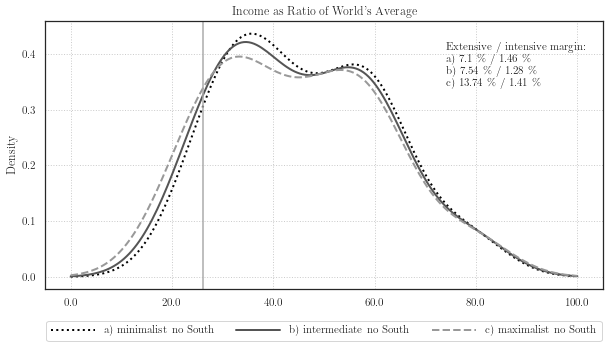

In [71]:
m5.out_distplot([m4,m6],text=True,save=True,save_name='nosouth.pdf',cols=3)

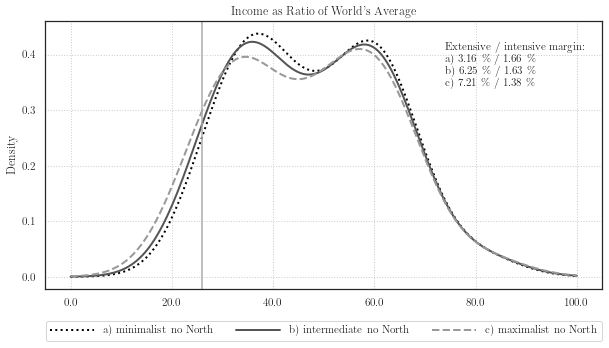

In [53]:
m8.out_distplot([m7,m9],text=True,save=True,save_name='nonorth.pdf',cols=3)

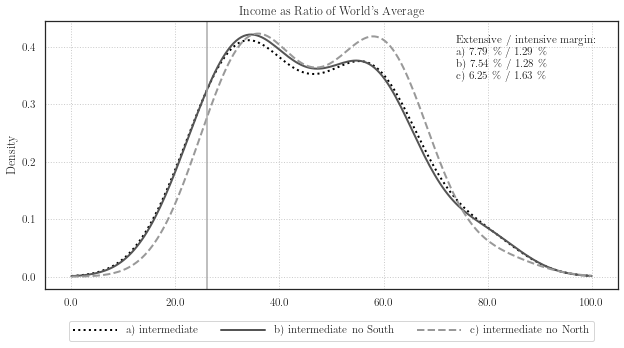

In [54]:
m1.out_distplot([m4,m7],text=True,save=True,save_name='full_nosouth_nonorth.pdf',cols=3)

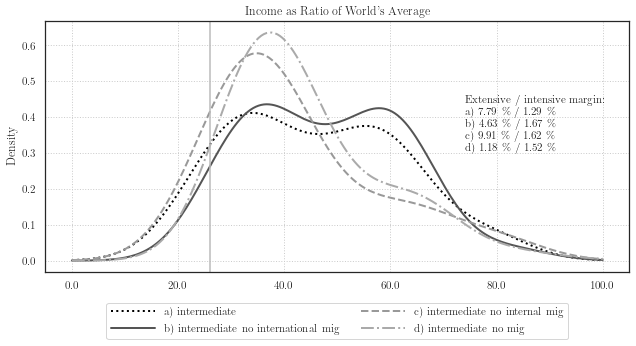

In [55]:
m1.out_distplot([m13,m14,m15],text=True,save=True,save_name='closing_borders.pdf',cols=2)

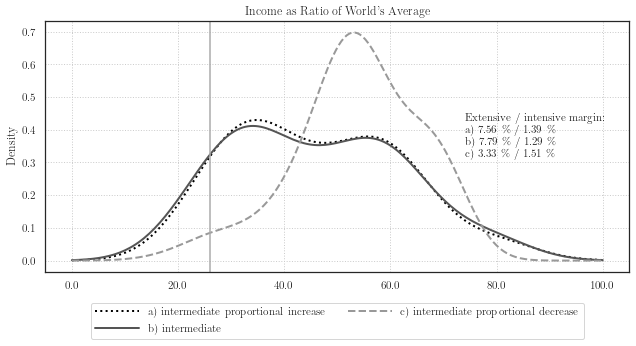

In [112]:
m11.out_distplot([m1,m12],text=True,cols=2)

### Compensating forcibly displaced people

#### Effect of xrr=0: World distribution of income~/World dist. of utility (accounting for 1-x)~
Very small effect. Flooding in general does not have a large impact. See below.

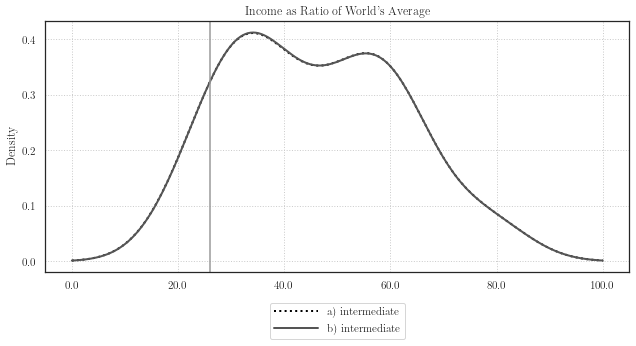

In [121]:
m1.out_distplot([m10])

## Appendix
Focus on the Intermediate scenario (as in Appendix C of my JDE paper: https://ars.els-cdn.com/content/image/1-s2.0-S0304387819302780-mmc1.pdf)

#### Table with World Aggregates in 2010, 2040, 2070, 2100 (cols): Population, Share of urban, Share of Colle grads, GDP per capita (rows).

In [453]:
display(m1.out_world_aggregates())
display(m1.out_world_aggregates(on='georegion'))

t,2010,2040,2070,2100
Population in 10000000.0,313.45,373.97,396.57,413.60
Urban Share in \%,54.14,56.88,56.62,54.81
HS Share in \%,8.97,23.01,23.33,22.53
GDP per Worker,21180.06,36107.66,34742.12,33311.61
GDP in 10000000000.0 \$US,6638.92,13503.06,13777.85,13777.79


t                                        2010       2040       2070       2100
                          georegion                                           
Population in 10000000.0  Africa        35.26      69.85     116.42     179.80
                          Americas      43.26      49.30      43.85      36.06
                          Asia         194.96     221.61     210.56     177.41
                          Europe        38.37      31.23      23.67      18.17
                          Oceania        1.61       1.97       2.06       2.16
Urban Share in \%         Africa        41.85      40.84      40.76      40.16
                          Americas      79.81      85.55      88.82      91.26
                          Asia          46.63      52.27      55.60      58.90
                          Europe        73.83      79.31      83.51      87.62
                          Oceania       73.77      70.73      62.49      54.33
HS Share in \%            Africa         3.34       7.10       7.15       6.78
                          Americas      17.88      49.29      53.15      58.06
                          Asia           6.14      18.08      22.27      27.23
                          Europe        18.07      50.40      55.15      59.76
                          Oceania       19.78      49.35      45.15      40.36
GDP per Worker            Africa      5436.69    7611.06    7688.44    7503.81
                          Americas   51297.69  112604.82  128141.94  152039.20
                          Asia       10662.76   17004.30   18758.90   21490.25
                          Europe     52560.56  108087.23  128091.78  156934.34
                          Oceania    82590.95  139835.45  136273.72  130001.87
GDP in 10000000000.0 \$US Africa       191.67     531.62     895.10    1349.15
                          Americas    2218.95    5551.13    5619.50    5483.27
                          Asia        2078.84    3768.38    3949.96    3812.59
                          Europe      2016.84    3376.10    3031.95    2852.18
                          Oceania      132.62     275.83     281.34     280.60

- [ ] Figure with region shares in 2010, 2040, 2070, 2100: in Population, in Urban population, in College-educated population, in total GDP (4 sub-figures)

- [ ] Table with Emigration rates by Region in 2010, 2040, 2070, 2100 (cols): all regions (rows)

In [102]:
m1.out_emigration_rate_by_wbregion()

,2010,2040,2070,2100
wbregion,,,,
EAS,1.56,2.70,2.92,3.06
ECS,8.93,9.72,9.61,9.44
LCN,5.51,5.04,4.07,3.20
MEA,7.41,8.03,9.01,9.80
NAC,1.15,1.50,1.21,1.02
SAS,3.72,4.12,4.54,5.03
SSF,4.09,4.03,4.01,4.16


- [ ] Table with Immigration rates by Region in 2010, 2040, 2070, 2100 (cols): all regions (rows)

In [103]:
m1.out_immigration_rate_by_country()

t,1980,2010,2040,2070,2100
Country,,,,,
Germany,NaN,23.32,35.22,44.51,53.21
France,NaN,23.66,38.96,51.18,64.51
United Kingdom,NaN,24.49,50.08,67.36,81.61
Italy,NaN,15.03,23.12,31.26,40.89
Spain,NaN,20.68,33.75,41.52,48.07
United States,NaN,25.13,40.75,47.56,52.82
Canada,NaN,38.84,69.03,81.87,90.07
Australia,NaN,45.00,64.84,73.92,80.89


- [ ] Figures with decomposition of mover stocks in 2010, 2040, 2070, 2100: one figure per region of origin; shares of local, interregional, international S-S, international S-N

- [ ] Figures with decomposition of mover stocks in 2010, 2040, 2070, 2100: one figure per region of destination; shares of local, interregional, S-S, S-N

- [ ] In the Minimalist scenario: World distribution of income  / World dist. of utility (accounting for 1-x)

## Additional plots & tables

In [509]:
m1.out_world_aggregates('income_group')

t                                                    2010       2040  \
                                   income_group                        
Population in           10000000.0 HIC              54.50      52.09   
                                   LIC              19.80      33.50   
                                   LMC             111.92     162.98   
                                   UMC             127.23     125.41   
Urban Share in \%                  HIC              80.51      87.30   
                                   LIC              37.70      34.73   
                                   LMC              38.08      40.24   
                                   UMC              59.53      71.78   
HS Share in \%                     HIC              20.66      59.42   
                                   LIC               6.46       5.64   
                                   LMC               6.03      13.40   
                                   UMC               6.95      25.02   
GDP per Worker                     HIC           81565.78  176677.80   
                                   LIC            7421.76    5500.83   
                                   LMC            4049.63    6001.83   
                                   UMC           12521.52   25024.65   
GDP in        10000000000.0 \$US   HIC            4445.64    9202.41   
                                   LIC             146.96     184.28   
                                   LMC             453.22     978.15   
                                   UMC            1593.10    3138.22   

t                                                     2070       2100  
                                   income_group                        
Population in           10000000.0 HIC               43.96      36.86  
                                   LIC               56.86      99.24  
                                   LMC              189.02     194.06  
                                   UMC              106.74      83.44  
Urban Share in \%                  HIC               90.98      93.65  
                                   LIC               33.25      32.44  
                                   LMC               43.48      46.92  
                                   UMC               78.18      82.63  
HS Share in \%                     HIC               62.11      65.28  
                                   LIC                4.43       3.56  
                                   LMC               15.66      17.82  
                                   UMC               31.00      37.14  
GDP per Worker                     HIC           201189.17  230920.59  
                                   LIC             3753.92    3038.49  
                                   LMC             7397.93    9253.45  
                                   UMC            31121.39   37971.94  
GDP in        10000000000.0 \$US   HIC             8844.20    8512.24  
                                   LIC              213.45     301.54  
                                   LMC             1398.32    1795.76  
                                   UMC             3321.88    3168.25

## Clean up here

In [48]:
def world_stock_text_table(mod_int, mod_max, mod_min,latex=False):
    int_min = (mod_int.out_migrant_world_stock()-mod_min.out_migrant_world_stock())
    max_min = (mod_max.out_migrant_world_stock()-mod_min.out_migrant_world_stock())
    int_min['Type'] = int_min.index
    int_min['Type'] = int_min.Type.str.split('-').apply(lambda x: x[-1])
    int_min = int_min.groupby('Type').sum()
    max_min['Type'] = max_min.index
    max_min['Type'] = max_min.Type.str.split('-').apply(lambda x: x[-1])
    max_min = max_min.groupby('Type').sum()
    out = round(pd.concat([int_min,max_min],0,keys=['int-min','max-min']),4)
    if latex == True:
        out = out.to_latex(bold_rows=True,multirow=True)
    return(out)

In [49]:
#table = world_stock_text_table(m1, m3, m2)
table = world_stock_text_table(m7, m9, m8,latex=False)
table

t                      2010     2040     2070     2100
        Type                                          
int-min Interregional   0.0   6.8123   7.4511   6.7687
        Local           0.0  51.4475  63.4513  64.6335
        North           0.0   0.0000   0.0000   0.0000
        South           0.0   0.9458   1.3105   1.4145
max-min Interregional   0.0  17.6921  19.3687  16.6290
        Local           0.0  61.1452  72.6929  74.0761
        North           0.0   0.0000   0.0000   0.0000
        South           0.0   0.8343   1.6212   1.7901

In [44]:
print(table)

t                      2010     2040     2070     2100
        Type                                          
int-min Interregional   0.0   6.8123   7.4511   6.7687
        Local           0.0  51.4475  63.4513  64.6335
        North           0.0   0.0000   0.0000   0.0000
        South           0.0   0.9458   1.3105   1.4145
max-min Interregional   0.0  17.6921  19.3687  16.6290
        Local           0.0  61.1452  72.6929  74.0761
        North           0.0   0.0000   0.0000   0.0000
        South           0.0   0.8343   1.6212   1.7901


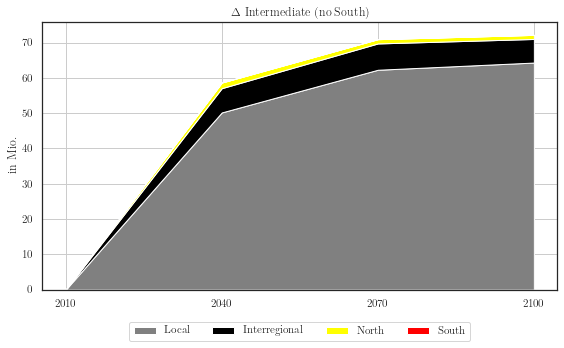

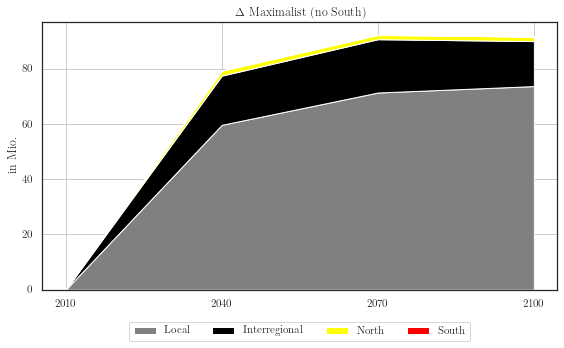

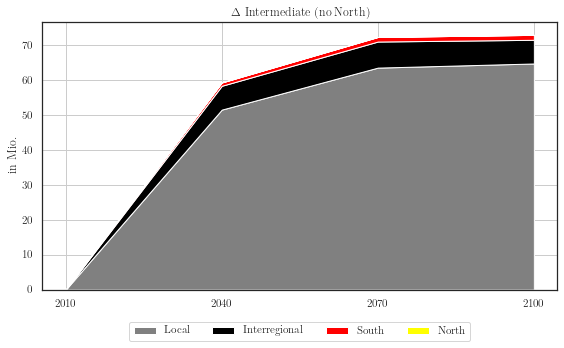

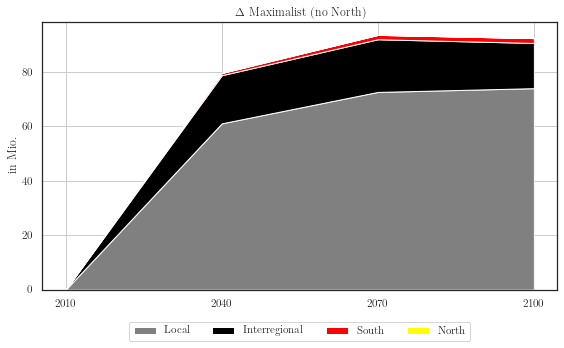

In [424]:
stackplot(m4,m5,save=True,name='int_min_nosouth.pdf',title='$\Delta$ Intermediate (no South)')
stackplot(m6,m5,save=True,name='max_min_nosouth.pdf',title='$\Delta$ Maximalist (no South)')
stackplot(m7,m8,save=True,name='int_min_nonorth.pdf',title='$\Delta$ Intermediate (no North)')
stackplot(m9,m8,save=True,name='max_min_nonorth.pdf',title='$\Delta$ Maximalist (no North)')

In [109]:
# b = False
# OECD = False

# dic = {
#     'Iij': 'International immigration',
#     'Iii': 'Internal immigration',
#     'Ms': 'Locally displaced people'}

# for var in ['Ms','Iij','Iii']:
#     for t in [2100]:
#         count = 0
#         for by in ['country','georegion','wbregion']:
#             for r in R:
#                 for s in S:
#                     count += 1
#                     fig = plt.figure(figsize=(25,7.5))
#                     a = m1.__dict__[var] - m2.__dict__[var]
#                     b = m3.__dict__[var] - m2.__dict__[var]
#                     c = m4.__dict__[var] - m5.__dict__[var]
#                     d = m6.__dict__[var] - m5.__dict__[var]

#                     if var == 'Ms':
#                         a = a.xs('f',1,2)
#                         b = b.xs('f',1,2)
#                         c = c.xs('f',1,2)
#                         d = d.xs('f',1,2)

#                     if OECD == True:
#                         a = a[m1.OECD == 1]
#                         b = b[m1.OECD == 1]
#                         c = c[m1.OECD == 1]
#                         d = d[m1.OECD == 1]

#                     if by != 'country':
#                         a.index = pd.Series(a.index).replace(list(m1.__dict__[by].index),list(m1.__dict__[by]))
#                         b.index = pd.Series(b.index).replace(list(m1.__dict__[by].index),list(m1.__dict__[by]))
#                         c.index = pd.Series(c.index).replace(list(m1.__dict__[by].index),list(m1.__dict__[by]))
#                         d.index = pd.Series(d.index).replace(list(m1.__dict__[by].index),list(m1.__dict__[by]))

#                         a = a.reset_index().groupby('Country').sum()
#                         b = b.reset_index().groupby('Country').sum()
#                         c = d.reset_index().groupby('Country').sum()
#                         d = d.reset_index().groupby('Country').sum()
#                     else:
#                         a.index = m1.iso
#                         b.index = m1.iso
#                         c.index = m1.iso
#                         d.index = m1.iso
                        
#                         fig = plt.figure(figsize=(25,7.5))
#                         plt.tick_params(axis='x', labelsize=8)

#                     if by == 'subregion':
#                         ms = 12
#                     if by == 'country':
#                         ms = 10

#                     plt.plot(a.xs(t,1,2)[r][s].sort_values(),marker='o',linewidth=0,markersize=ms*1.0,label='bilateral migration, intermediate - minimalist')
#                     plt.plot(b.xs(t,1,2)[r][s].sort_values(),marker='o',linewidth=0,markersize=ms*0.8,label='bilateral migration, maximalist - minimalist')
#                     plt.plot(c.xs(t,1,2)[r][s].sort_values(),marker='o',linewidth=0,markersize=ms*0.6,label='only OECD migration, intermediate - minimalist')
#                     plt.plot(d.xs(t,1,2)[r][s].sort_values(),marker='o',linewidth=0,markersize=ms*0.4,label='only OECD migration, maximalist - minimalist')
#                     plt.title("%s by %s, region = %s, skill = %s, year = %s"%(dic[var],by,r,s,t))
#                     rcParams.update({'figure.autolayout': True})
#                     plt.tight_layout()
#                     plt.xticks(rotation='vertical')
#                     plt.legend()
#                     plt.grid(ls=':')
#                     fig.savefig('graphs/movers/%s_%s_%s_%s.pdf' % (by,var,str(t),str(count)))
#                     plt.show()


In [110]:
var = ['A','D','Γ__L']
df = pd.concat([self.__dict__[v] for v in var],axis=1,keys=var)
df.columns.names = ['Variable','r','t']
df = df.unstack().reset_index()
df = df[(df['t'] == 2010) | (df['t'] == 1980)]
df['t'] = df.t.replace([1980,2010],[0,1])
df = df.set_index(['Country','Variable','r','t'])[0].unstack(level=[1,2])
#df = df.reset_index(level=1)

NameError: name 'self' is not defined

In [ ]:
df = df.xs(r,1,1)
df = df.reset_index(level=1)

In [ ]:
reg = sm.ols(formula="np.log(A) - np.log(D) ~ np.log(Γ__L) + t",data=df).fit()

In [ ]:
reg.params['t']

In [ ]:
%%time
m1 = model(name="intermediate, bilateral mig", tol=1e-5, scenario='intermediate')
m1.correct_south_south()
m1.calib_kappa()
m1.calib_A()

self = m1
self.ε = {'a': np.nan, 'n': np.nan}             # aggregate externality
self.A_bar = pd.DataFrame(index=self.countries) # scale factor in TFP

A_D = pd.concat([m1.A.xs(1980,1,1)/m1.D.xs(1980,1,1),m1.A.xs(2010,1,1)/m1.D.xs(2010,1,1)],1,keys=[1980,2010]).swaplevel(1,0,1)

df = pd.concat([self.A,self.Γ__L],1,keys=['A','Γ__L'])

def reg(r):
    df = self.A[r].melt(var_name='year2010',value_name='A')
    df = df.join(self.Γ__L[r].melt(var_name='year2010'
                                   ,value_name='Γ__L')['Γ__L'])
    df['year2010'] = np.where(df.year2010 == 2010,1,0)

    reg = sm.ols(formula="np.log(A) ~ np.log(Γ__L) + year2010", 
                 data=df).fit()

    return(reg.params)

self.γ = reg('a')['year2010'] ** (1/30)
self.γ = 1.00256317290118    

t = 2010
for r in R:
    self.ε[r] = 0.5 * reg(r)['np.log(Γ__L)']
    self.A_bar[r] = self.A[(r,t)]/(self.γ * self.Γ__L[(r,t)]**self.ε[r] * self.D[(r,t)])

In [ ]:
self.ε

In [458]:
m1.out_sankeyplot(aggr_source_by='bddm',aggr_target_by='bddm')

SankeyWidget(layout=Layout(height='800', width='800'), links=[{'source': 'CARE', 'target': 'CARE ', 'value': 7…